# Act 2: Iterating with Data


In this notebook, you'll add another layer of context to your video pipeline. In Act 01, we added visual search based on evenly spaced frames from the video. Here we'll add more context in two ways. First, we'll apply content-aware scene detection. Second, we'll add audio signals to the mix by extracting the audio channel, transcribing it, then adding an embedding index for the text. This typically means chaining together separate tools: FFmpeg for audio extraction, Whisper for transcription, sentence splitters, text embedding models, and vector databases.

The techniques you'll learn apply to any content that needs breaking down into processable chunks:

- Breaking videos into logical segments (scenes, chapters, clips)
- Processing long-form audio (podcasts, interviews, lectures)
- Chunking documents for better search granularity

## In this notebook
1. **Detect Scene Boundaries** - Automatically identify scene changes using content-aware detection
2. **Iterate Over Scenes** - Create a view with one row per scene for independent processing
3. **Process Each Scene** - Extract audio and generate transcripts with computed columns
4. **Search Across Scenes** - Split transcripts into sentences and build semantic search

In [1]:
import pixeltable as pxt
import pixeltable.functions as pxtf

In [2]:
pxt.list_tables()

Connected to Pixeltable database at: postgresql+psycopg://postgres:@/pixeltable?host=/Users/alison-pxt/.pixeltable/pgdata


['primetime_vids']

In [3]:
v = pxt.get_table('primetime_vids')

In [4]:
v

table 'primetime_vids'

 Column Name    Type        Computed With
       video   Video                     
       title  String                     
   promo_img   Image                     
  promo_text  String                     
    duration   Float  get_duration(video)

## 01 - Detect Scene Boundaries

In Act 1, we extracted frames at regular intervals to get a specific number of frames. However, those frames might not reflect meaningful scene breaks - they're just evenly spaced snapshots of the video.

Here in Act 2, we'll use **content-aware scene detection** to find actual scene boundaries - places where the content changes significantly, not just arbitrary time intervals. 

This functionality in Pixeltable is once again a set of user-defined functions (UDF). Pixeltable exposes the [PySceneDetect](https://www.scenedetect.com/features/) package as a collection of UDFs. PySceneDetect is a popular way to detect breaks in-between video content, identifying where meaningful scene changes occur. Alternatively, you could bring your own scene detection Python library, and wrap the functions as UDFs that Pixeltable can now execute. 

We'll use content-based scene detection with tuned parameters to find these meaningful scene breaks. Learn more about [scene detection functions](https://docs.pixeltable.com/sdk/latest/video) and the [`scene_detect_histogram()`](https://docs.pixeltable.com/sdk/latest/video#udf-scene_detect_histogram) function:

In [5]:
# Add scene detection with tuned parameters
v.add_computed_column(
    scenes=v.video.scene_detect_histogram(
        fps=10,
        threshold=0.6,
        min_scene_len=100
    ),
    if_exists='replace'
)

objc[7194]: Class AVFFrameReceiver is implemented in both /Users/alison-pxt/Documents/Github/pxt-primetime/.venv/lib/python3.13/site-packages/av/.dylibs/libavdevice.62.1.100.dylib (0x1234843a8) and /Users/alison-pxt/Documents/Github/pxt-primetime/.venv/lib/python3.13/site-packages/cv2/.dylibs/libavdevice.61.3.100.dylib (0x36894c3a8). This may cause spurious casting failures and mysterious crashes. One of the duplicates must be removed or renamed.
objc[7194]: Class AVFAudioReceiver is implemented in both /Users/alison-pxt/Documents/Github/pxt-primetime/.venv/lib/python3.13/site-packages/av/.dylibs/libavdevice.62.1.100.dylib (0x1234843f8) and /Users/alison-pxt/Documents/Github/pxt-primetime/.venv/lib/python3.13/site-packages/cv2/.dylibs/libavdevice.61.3.100.dylib (0x36894c3f8). This may cause spurious casting failures and mysterious crashes. One of the duplicates must be removed or renamed.


Added 1 column value with 0 errors in 40.46 s (0.02 rows/s)


1 row updated.

**What happens when you use `scene_detect_histogram()`:**

This UDF analyzes the video frame-by-frame (at 10 frames per second) to detect visual changes. The algorithm:

- Compares frames in HSL (Hue, Saturation, Lightness) color space to measure visual differences
- Uses a threshold of 0.6 to determine if a change is significant enough to mark a scene boundary  
- Ensures each detected scene is at least 100 frames long (10 seconds at 10 fps) to filter out brief flashes

This typically takes about a minute for a 6-minute video. The output will be a list of dictionaries, where each dictionary contains scene `start_time`, `start_pts`, and `duration` keys.

**Understanding the parameters:**
- `fps=10`: Analyzes 10 frames per second (balancing speed vs. accuracy)
- `threshold=0.6`: Sensitivity for detecting scene changes (lower = more sensitive)
- `min_scene_len=100`: Minimum scene length in frames (prevents very short false positives)


The `scenes` column contains a JSON array with scene boundaries. Check the updated table schema:


In [6]:
v

table 'primetime_vids'

 Column Name    Type                                      Computed With
       video   Video                                                   
       title  String                                                   
   promo_img   Image                                                   
  promo_text  String                                                   
    duration   Float                                get_duration(video)
      scenes    Json  video.scene_detect_histogram(fps=10,\n    thre...

video,scenes
,"[{""duration"": 28.779, ""start_pts"": 0, ""start_time"": 0.}, {""duration"": 16.85, ""start_pts"": 690690, ""start_time"": 28.779}, {""duration"": 80.122, ""start_pts"": 1095094, ""start_time"": 45.629}, {""duration"": 28.737, ""start_pts"": 3018015, ""start_time"": 125.751}, {""duration"": 25.734, ""start_pts"": 3707704, ""start_time"": 154.488}, {""duration"": 51.301, ""start_pts"": 4325321, ""start_time"": 180.222}, {""duration"": 70.32, ""start_pts"": 5556551, ""start_time"": 231.523}, {""duration"": 7.132, ""start_pts"": 7244237, ""start_time"": 301.843}, {""duration"": 41.458, ""start_pts"": 7415408, ""start_time"": 308.975}, {""duration"": 11.261, ""start_pts"": 8410402, ""start_time"": 350.433}]"

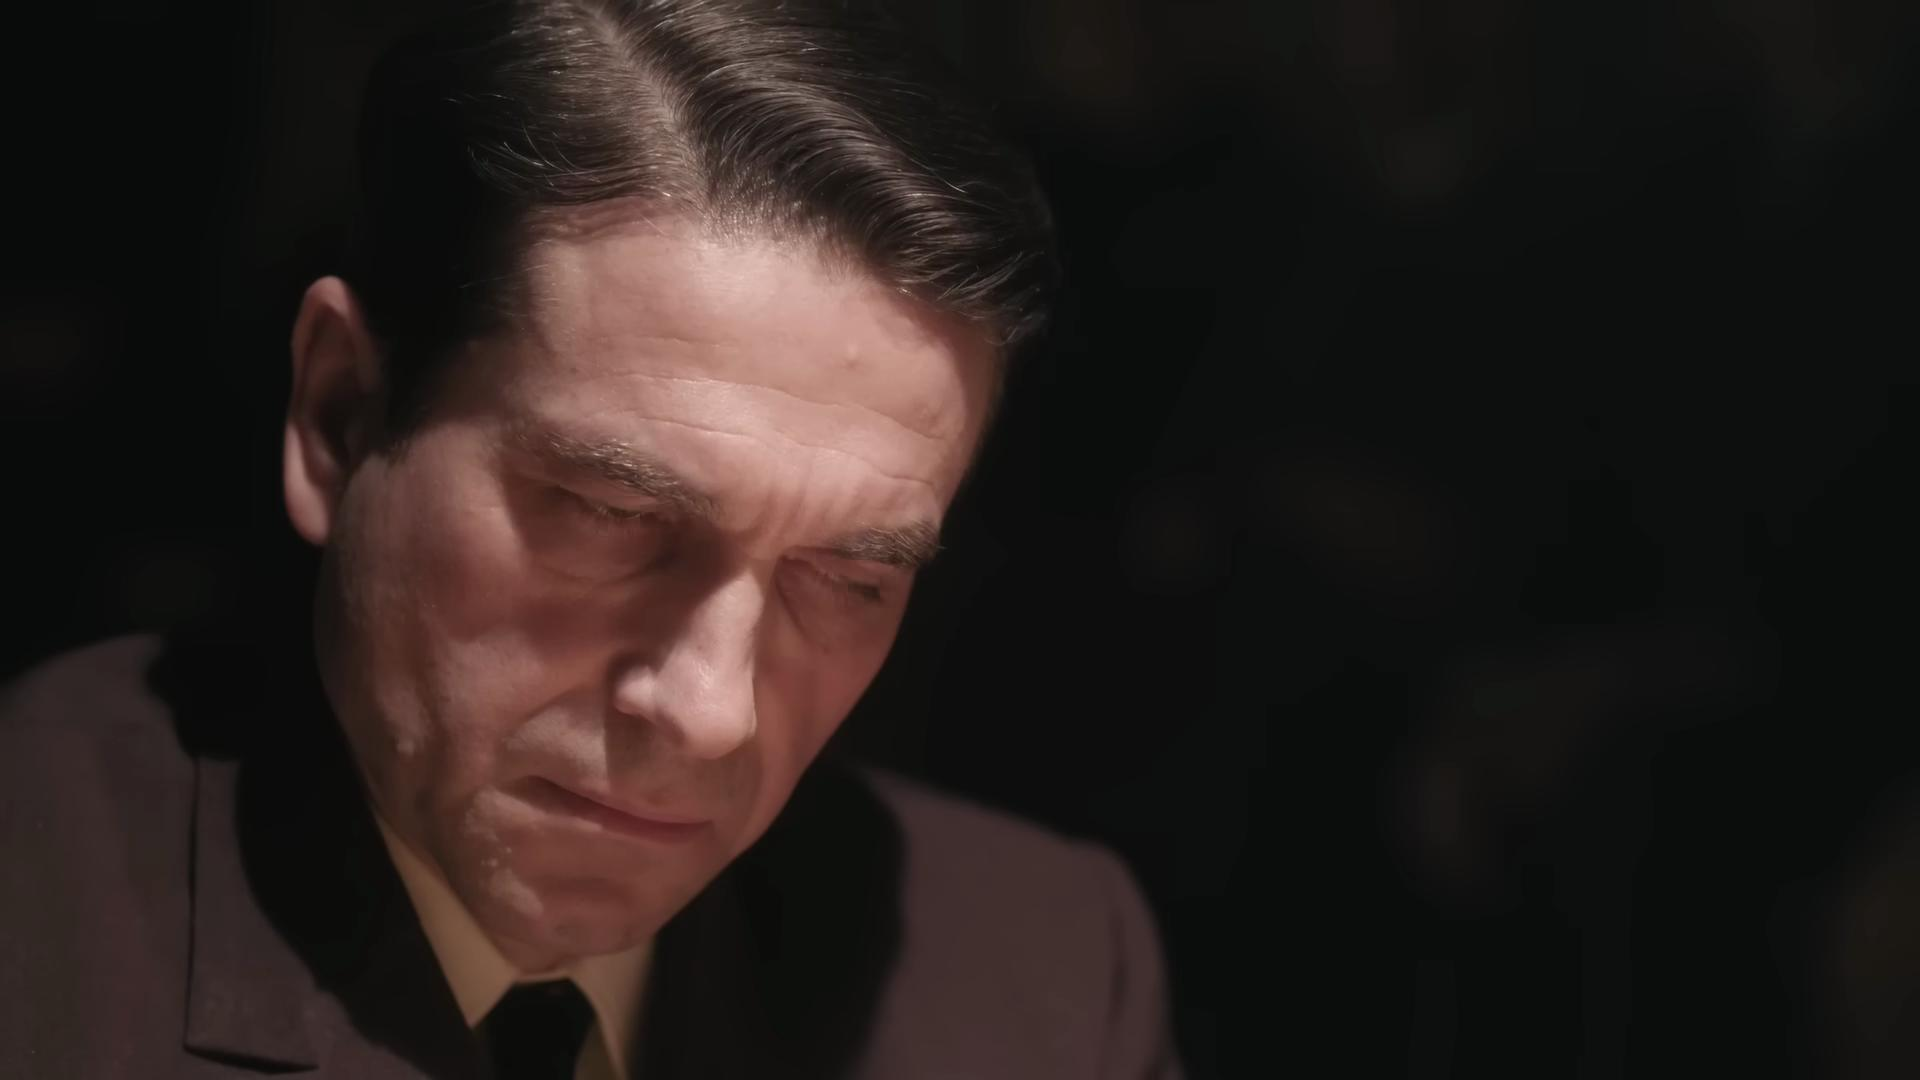

In [7]:
v.select(v.video, v.scenes).collect()

## 02 - Iterate Over Scenes

To create a view with video segments, we need to extract the scene start times from the `scenes` column. The [`video_splitter()`](https://docs.pixeltable.com/sdk/latest/video#iterator-video_splitter) iterator takes `segment_times` - an array of split points where the video should be divided.

<Explain> Pixeltable supports JSON path expressions, which allows us to extract exactly what we need to pass to the video splitter.

Learn more about [iterators](https://docs.pixeltable.com/platform/iterators) and [JSON operations](https://docs.pixeltable.com/platform/type-system).

In [22]:
# Let's look at this output
v.select(v.scenes['*'].start_time).collect()

scenes_star_starttime
"[0., 28.779, 45.629, 125.751, 154.488, 180.222, 231.523, 301.843, 308.975, 350.433]"


We don't want the first one, so we can also use Python slice notation to get only the part of the list we care about: We use `v.scenes[1:].start_time` to get these split points. We skip the first scene boundary (index 0, which is at time 0) because `video_splitter` automatically starts the first segment at 0. If we have split points at [30, 60, 90], we get 4 segments: 0-30, 30-60, 60-90, and 90-end.

In [16]:
# Run a query to extract a scene boundary
v.select(v.scenes[1:].start_time).collect()

scenes_1_starttime
"[28.779, 45.629, 125.751, 154.488, 180.222, 231.523, 301.843, 308.975, 350.433]"


In [23]:
scenes = pxt.create_view(
    'scene_view',
    v,
    iterator=pxtf.video.video_splitter(
        video=v.video,
        segment_times=v.scenes[1:].start_time, # this is from our scene detection
        mode='fast',
    ),
    if_exists='replace'
)

The view now has one row per scene segment. Let's check the schema and see what the iterator added to this view:


In [24]:
scenes

view 'scene_view' (of 'primetime_vids')

        Column Name             Type                                      Computed With
                pos    Required[Int]                                                   
      segment_start            Float                                                   
  segment_start_pts              Int                                                   
        segment_end            Float                                                   
    segment_end_pts              Int                                                   
      video_segment  Required[Video]                                                   
              video            Video                                                   
              title           String                                                   
          promo_img            Image                                                   
         promo_text           String                                                   
           duration            Float                                get_duration(video)
             scenes             Json  video.scene_detect_histogram(fps=10,\n    thre...

The [`video_splitter()`](https://docs.pixeltable.com/sdk/latest/video#iterator-video_splitter) iterator adds the following columns to the view:

- `pos`: Position/index of the segment
- `video_segment`: The actual video segment file
- `segment_start`: Start time of the segment in seconds
- `segment_end`: End time of the segment in seconds
- `segment_start_pts` / `segment_end_pts`: Presentation timestamps (for advanced use)

pos,segment_start,segment_end,video_segment
0,0.,28.779,
1,28.779,45.629,
2,45.629,125.751,

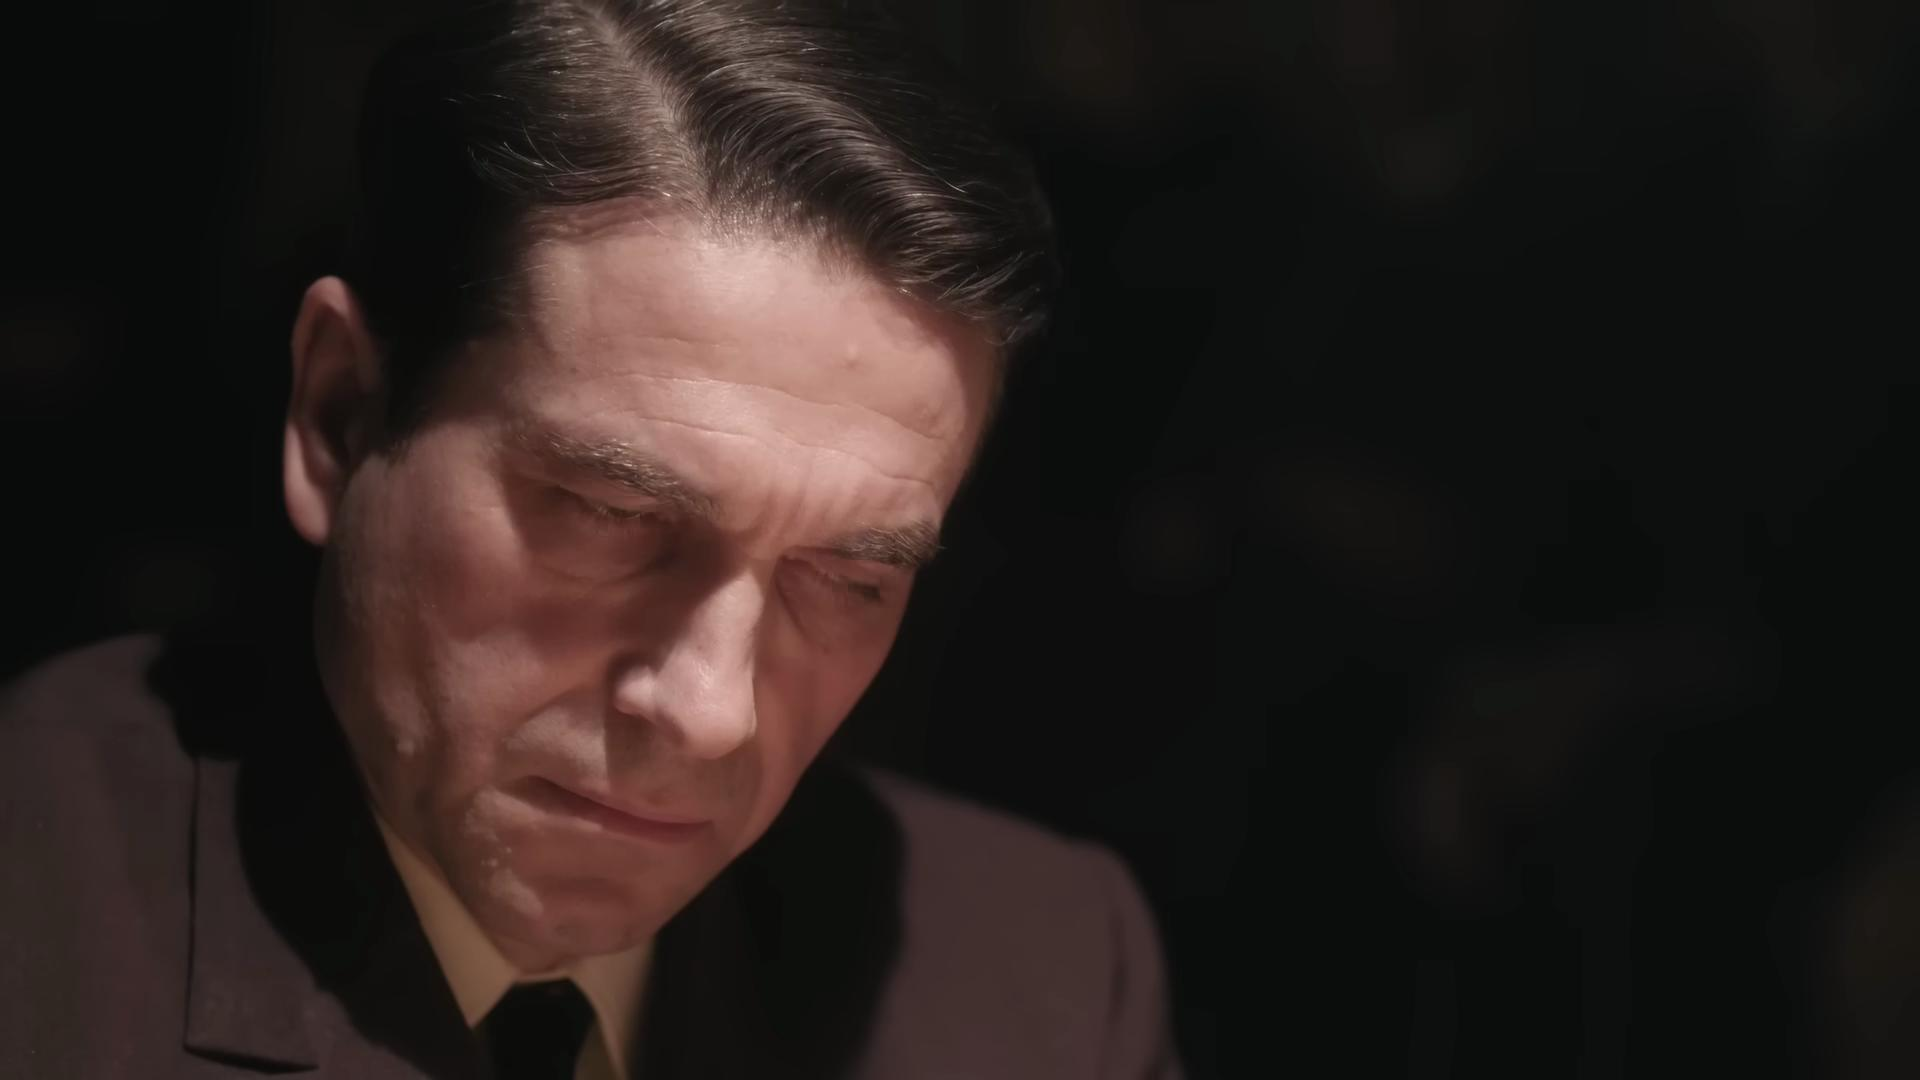
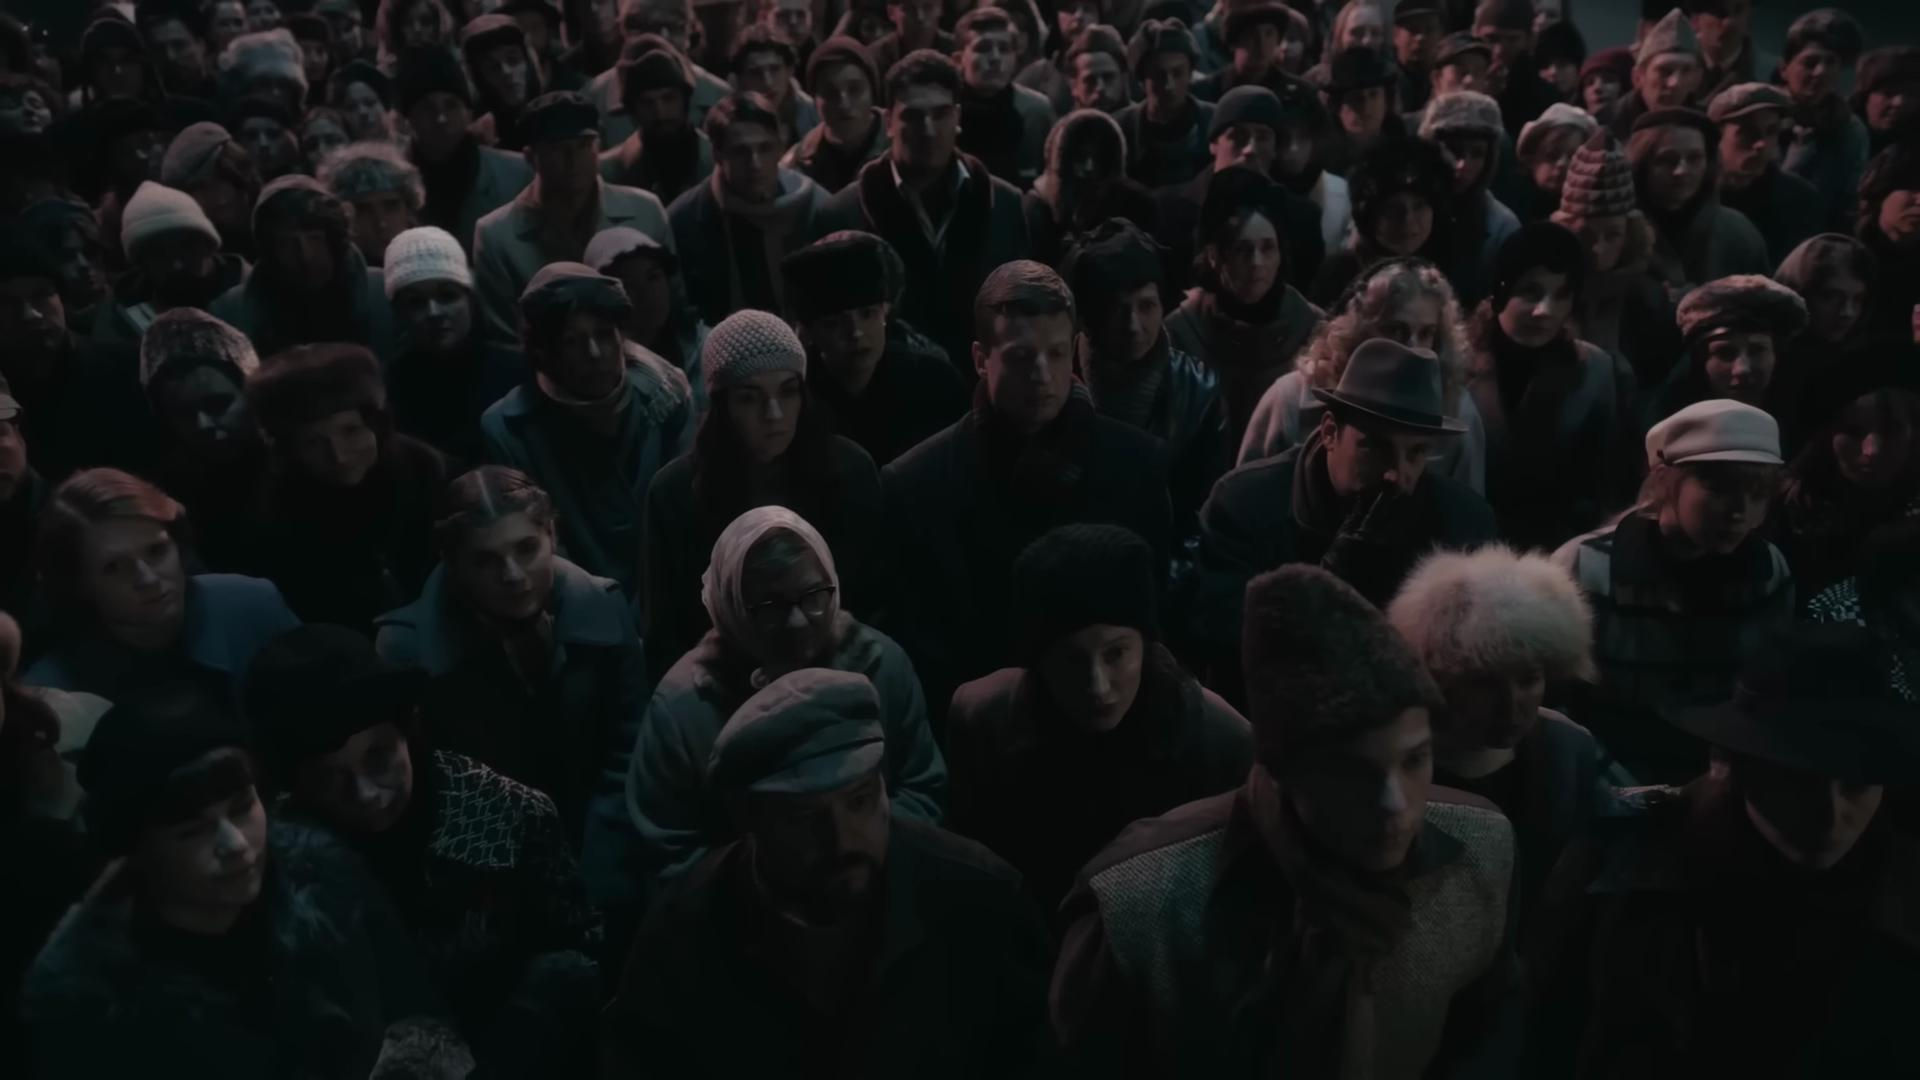
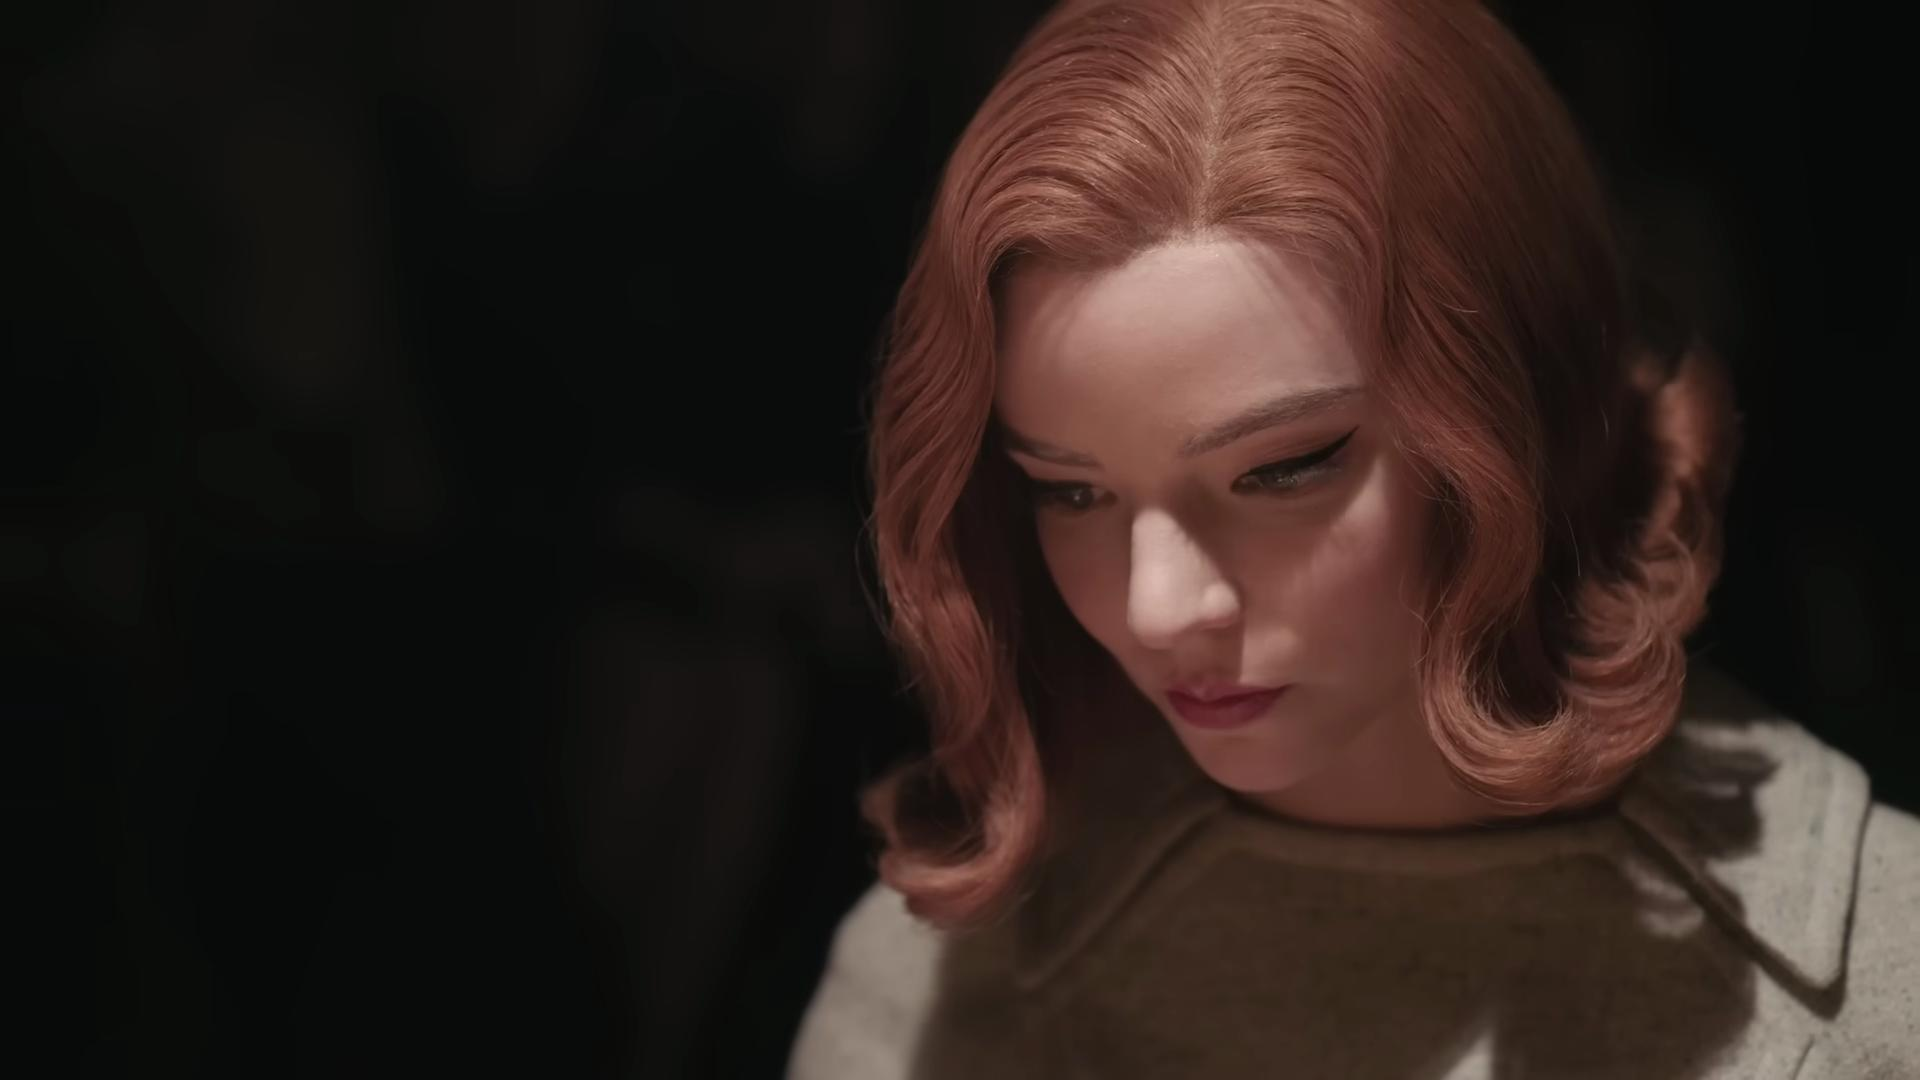

In [25]:
scenes.select(scenes.pos, scenes.segment_start, scenes.segment_end, scenes.video_segment).limit(3).collect()

## 03 - Process Each Scene

Let's enrich our scene view with audio and transcripts. We'll transcribe at the scene level, then split transcripts into sentences for better embedding granularity.

### Extract & Transcribe Audio

Extract audio from each scene's video segment so we can transcribe it. Pixeltable's `extract_audio()` UDF works for this:


In [26]:
scenes.add_computed_column(
    audio=pxtf.video.extract_audio(scenes.video_segment),
    if_exists='replace'
)

Added 10 column values with 0 errors in 0.37 s (26.78 rows/s)


10 rows updated.

In [27]:
scenes

view 'scene_view' (of 'primetime_vids')

        Column Name             Type                                      Computed With
                pos    Required[Int]                                                   
      segment_start            Float                                                   
  segment_start_pts              Int                                                   
        segment_end            Float                                                   
    segment_end_pts              Int                                                   
      video_segment  Required[Video]                                                   
              audio  Required[Audio]                       extract_audio(video_segment)
              video            Video                                                   
              title           String                                                   
          promo_img            Image                                                   
         promo_text           String                                                   
           duration            Float                                get_duration(video)
             scenes             Json  video.scene_detect_histogram(fps=10,\n    thre...

Transcribe audio using OpenAI's Whisper model. There are two options:

- **Local Whisper:** Free, no API key needed, but slower
- **OpenAI API:** Faster, but requires an API key and costs money

We'll use local Whisper for this example:


In [28]:
import warnings
warnings.filterwarnings('ignore')

scenes.add_computed_column(
    transcription=pxtf.whisper.transcribe(scenes.audio, model='base'),
    if_exists='replace'
)

Added 10 column values with 0 errors in 19.41 s (0.52 rows/s)


10 rows updated.

In [ ]:
# Alternative: Using OpenAI API for transcription (faster, but requires API key)
# Uncomment and use this instead of the built-in whisper function below
# 
# First, install the openai package: pip install openai
# Set your API key: export OPENAI_API_KEY='your-api-key-here'
# 
# scenes.add_computed_column(
#     api_tx=pxtf.openai.transcriptions(scenes.audio, model='whisper-1'),
#     if_exists='replace'
# )

Let's see the schema change since transcription returns JSON:

In [29]:
scenes

view 'scene_view' (of 'primetime_vids')

        Column Name             Type                                      Computed With
                pos    Required[Int]                                                   
      segment_start            Float                                                   
  segment_start_pts              Int                                                   
        segment_end            Float                                                   
    segment_end_pts              Int                                                   
      video_segment  Required[Video]                                                   
              audio  Required[Audio]                       extract_audio(video_segment)
      transcription   Required[Json]                    transcribe(audio, model='base')
              video            Video                                                   
              title           String                                                   
          promo_img            Image                                                   
         promo_text           String                                                   
           duration            Float                                get_duration(video)
             scenes             Json  video.scene_detect_histogram(fps=10,\n    thre...

Let's look at the transcription output:

pos,video_segment,transcription
4,,"{""text"": """", ""language"": ""en"", ""segments"": []}"

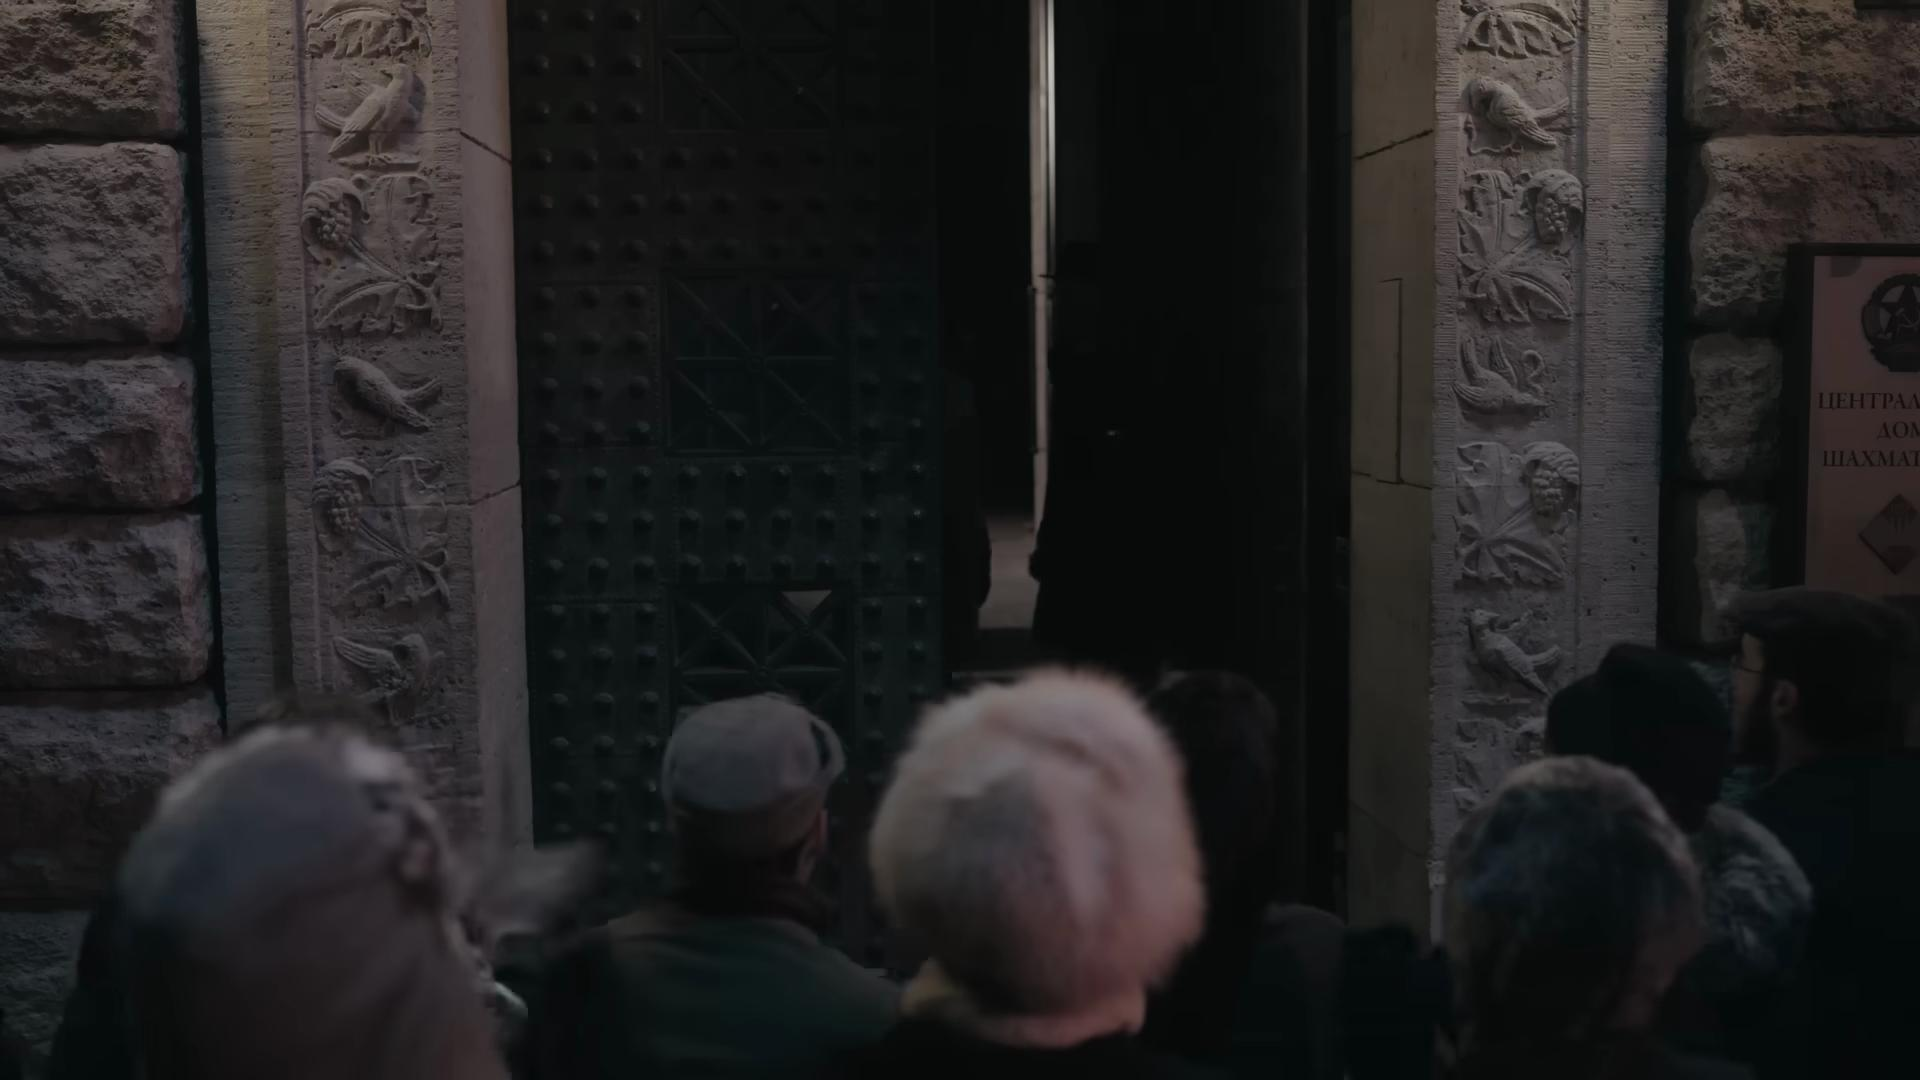

In [30]:
scenes.select(scenes.pos, scenes.video_segment, scenes.transcription).limit(1).collect()
#add a where clause for pos = 0

We can extract the text and language from the transcription JSON:

In [ ]:
scenes.select(scenes.transcription.text).collect()

transcription_text
""
"The President has invited you to the White House. There'll be a chess board set up in the Oval Office, and of course a photo op of you kicking his ass. Texas being more of a checker state. There's a dinner tonight after the reception at the Russian chess club in Georgetown. A lot of prominent visitors belong, so I'm going to have to go back to the White House. I'm going to have to go back to the White House. I'm going to have to go back to the White House. I'm going to have to go back to the White House. There's a food box for visitors belongs, so we prepare to listen to talking points. It's a big deal, beating the Soviets at the wrong game. Could you stop the car, please? I'd like to walk. To the airport."
That check has been the whole point of the sequence beginning with the bishop cutting down the slope of the book by forcing it to a last threatening left. Question is... What will she do now?
А Павлиалось ранку со старой кармы. Я не studying без Потомуpromоушенalia у тебя pastel в Айшаны.
It's your game. Take it. I'm gonna knock his door. What happened? A SAIDK! That's all! Whoo! Get out! A LO Joyce trailer
"Thank you. Good for you, Crackle. Good for you."
"You're gonna miss the flood? Come on. Come on. Lisa, come on."
Daha. plata ver Kansas
"Et on s'était appelés... Buena, au 20 mai et... Plus seul, au 20 mai. Non, non, non. Henri..."
"П declared, чтоanciale體 всеити прято hartного."


The `transcription_text` column has type JSON, which requires us to use a type cast if we want to process it as a string. 

We use `.astype(pxt.String)` to convert it from JSON to a string. This lets us work with the transcript text directly in queries and computed columns.

<consider> Pixeltable enforces type safety: if you want to pass the path expression `scenes.transcription.text` to a UDF that expects a string, you would first need to cast it. Otherwise, it would flag a type error.

In [32]:
# Extract the text and language from the transcription JSON
scenes.add_computed_column(
    transcript_text=scenes.transcription.text.astype(pxt.String),
    if_exists='replace'
)

scenes.add_computed_column(
    transcript_lang=scenes.transcription.language.astype(pxt.String),
    if_exists='replace'
)

Added 10 column values with 0 errors in 0.02 s (407.65 rows/s)
Added 10 column values with 0 errors in 0.02 s (536.68 rows/s)


10 rows updated.

In [33]:
scenes

view 'scene_view' (of 'primetime_vids')

        Column Name             Type                                      Computed With
                pos    Required[Int]                                                   
      segment_start            Float                                                   
  segment_start_pts              Int                                                   
        segment_end            Float                                                   
    segment_end_pts              Int                                                   
      video_segment  Required[Video]                                                   
              audio  Required[Audio]                       extract_audio(video_segment)
      transcription   Required[Json]                    transcribe(audio, model='base')
    transcript_text           String                  transcription.text.astype(String)
    transcript_lang           String              transcription.language.astype(String)
              video            Video                                                   
              title           String                                                   
          promo_img            Image                                                   
         promo_text           String                                                   
           duration            Float                                get_duration(video)
             scenes             Json  video.scene_detect_histogram(fps=10,\n    thre...

pos,video_segment,transcript_text,transcript_lang
4,,,en
5,,"The President has invited you to the White House. There'll be a chess board set up in the Oval Office, and of course a photo op of you kicking his ass. Texas being more of a checker state. There's a dinner tonight after the reception at the Russian chess club in Georgetown. A lot of prominent visitors belong, so I'm going to have to go back to the White House. I'm going to have to go back to the White House. I'm going to have to go back to the White House. I'm going to have to go back to the White House. There's a food box for visitors belongs, so we prepare to listen to talking points. It's a big deal, beating the Soviets at the wrong game. Could you stop the car, please? I'd like to walk. To the airport.",en
0,,That check has been the whole point of the sequence beginning with the bishop cutting down the slope of the book by forcing it to a last threatening left. Question is... What will she do now?,en

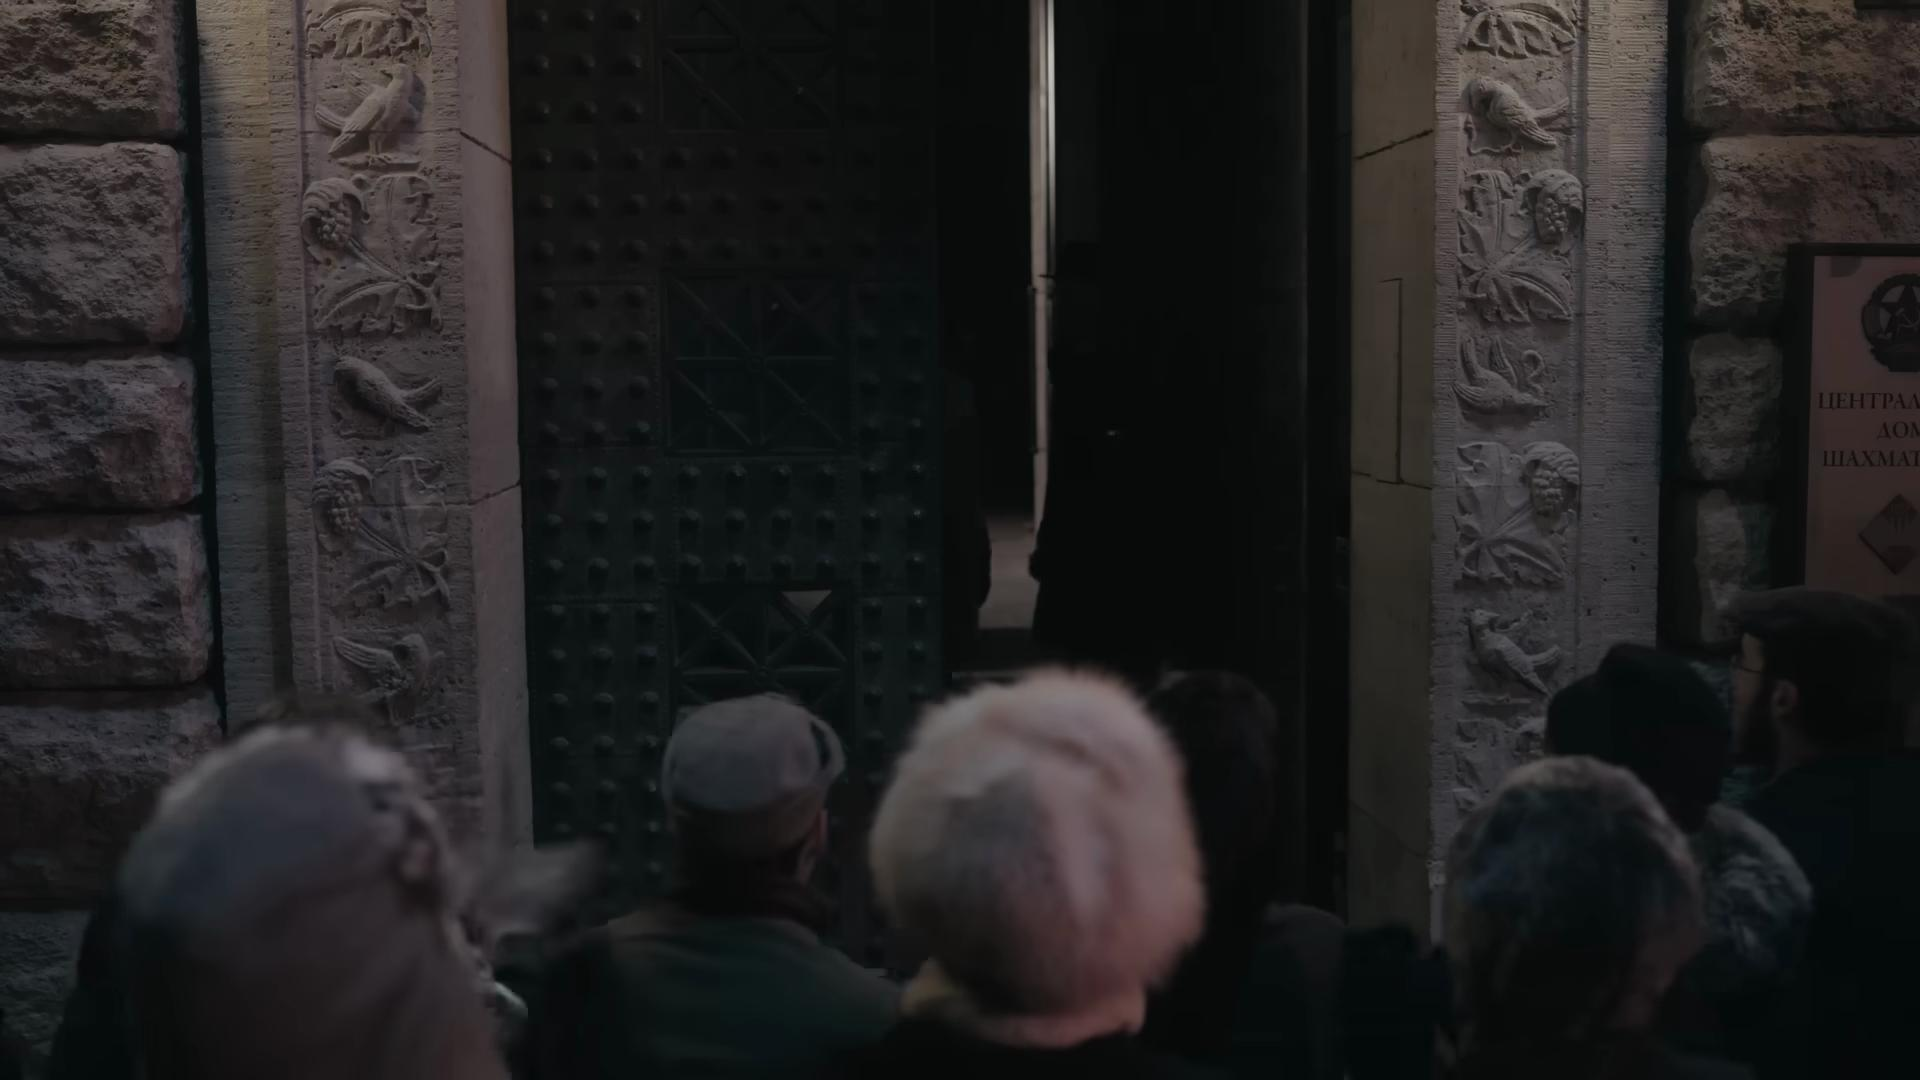
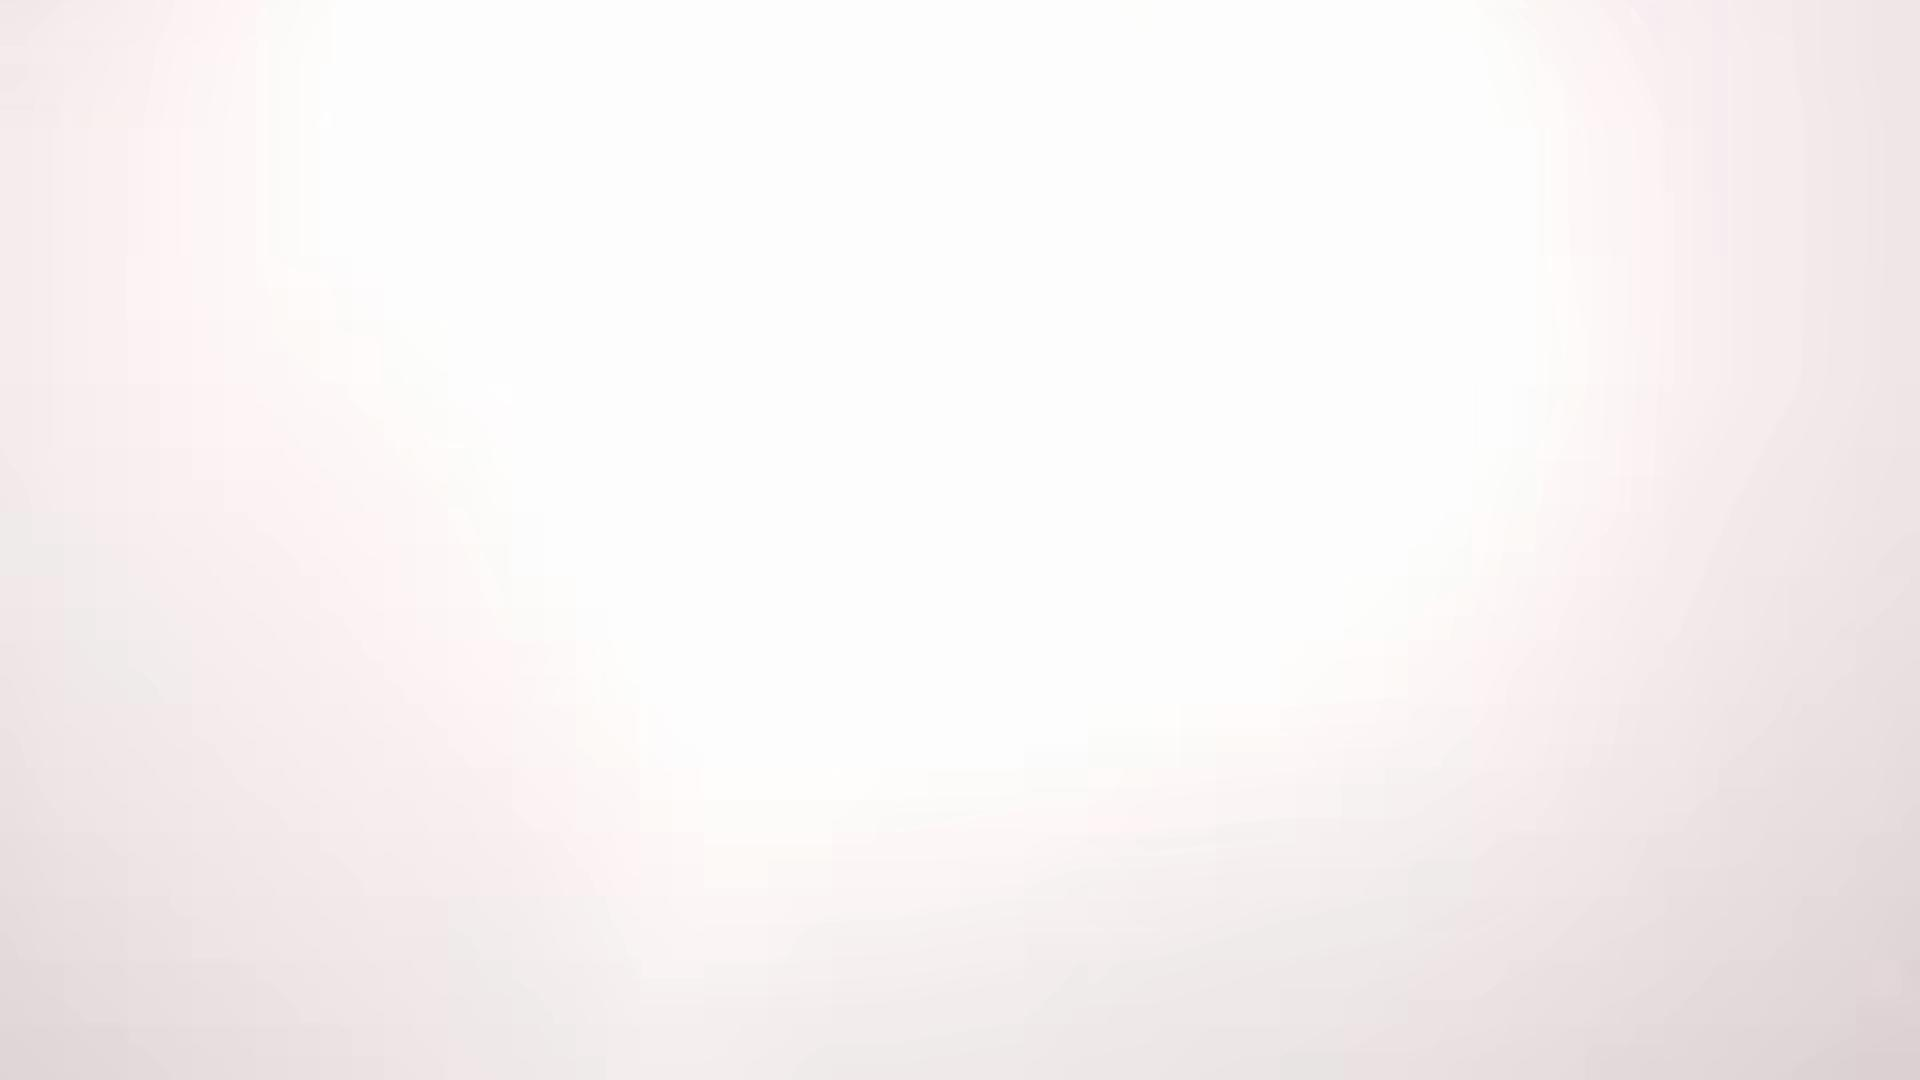
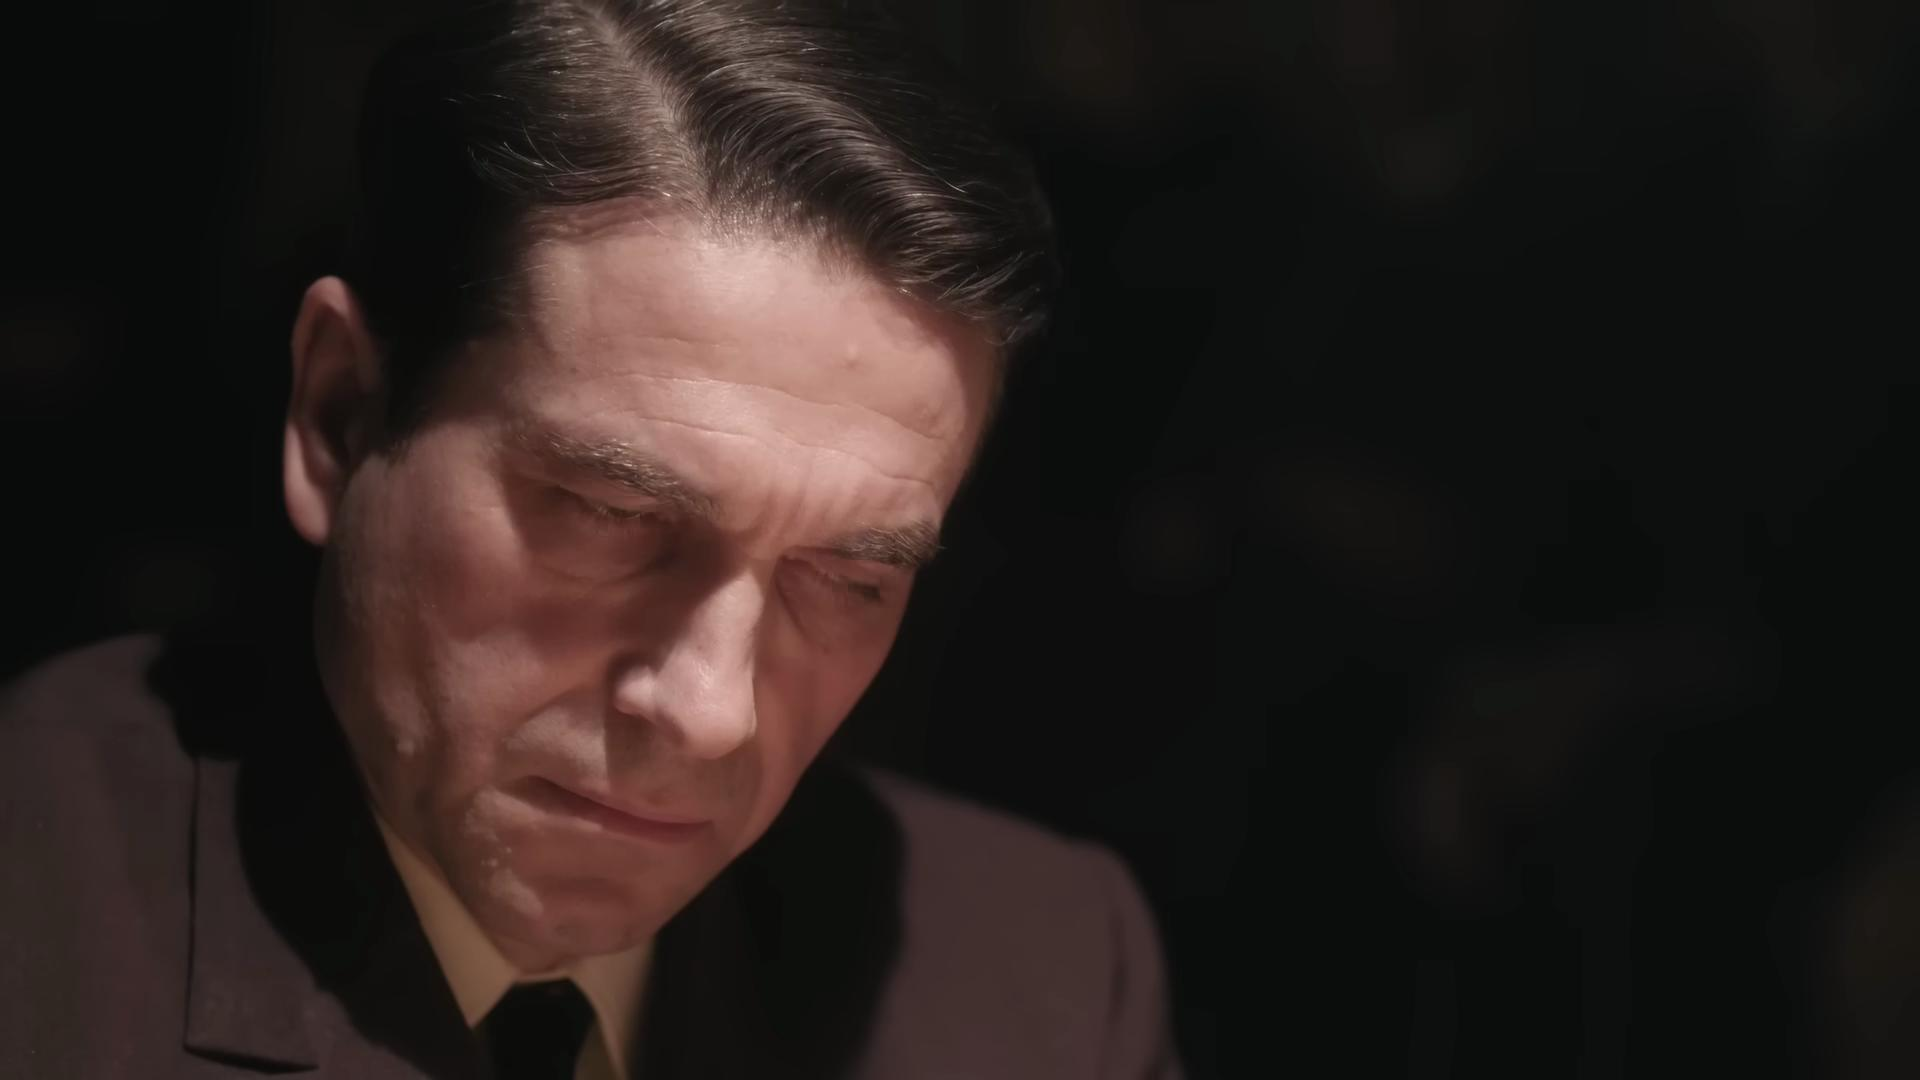

In [34]:
scenes.select(scenes.pos, scenes.video_segment, scenes.transcript_text, scenes.transcript_lang).limit(3).collect()

### Split Transcripts into Sentences

Embedding entire scene transcripts loses semantic granularity. A scene might discuss multiple topics, and embedding the whole transcript creates a single vector that blurs those distinctions.

We'll create another view that splits each scene's transcript into sentences using [`string_splitter()`](https://docs.pixeltable.com/sdk/latest/string). This gives us one row per sentence, which we can then embed and search with better precision.

In [35]:
# Create a view that splits transcripts into sentences
sentences = pxt.create_view(
    'sentences',
    scenes,
    iterator=pxtf.string.string_splitter(
        scenes.transcript_text,
        separators='sentence'
    )
)

The view now has one row per sentence. Let's check the schema:

In [36]:
sentences

view 'sentences' (of 'scene_view', 'primetime_vids')

        Column Name              Type                                      Computed With
                pos     Required[Int]                                                   
               text  Required[String]                                                   
      segment_start             Float                                                   
  segment_start_pts               Int                                                   
        segment_end             Float                                                   
    segment_end_pts               Int                                                   
      video_segment   Required[Video]                                                   
              audio   Required[Audio]                       extract_audio(video_segment)
      transcription    Required[Json]                    transcribe(audio, model='base')
    transcript_text            String                  transcription.text.astype(String)
    transcript_lang            String              transcription.language.astype(String)
              video             Video                                                   
              title            String                                                   
          promo_img             Image                                                   
         promo_text            String                                                   
           duration             Float                                get_duration(video)
             scenes              Json  video.scene_detect_histogram(fps=10,\n    thre...

<todo when we talk about iterator views, each one gets a position column in order to reconstruct>

In this case, the string splitter returns `pos` and `text`.

We now have a 3-level hierarchy:
1. Videos
2. Scenes (access to videos parent table)
3. Sentences (access to BOTH parent table)

<get text from transcript>

<JIRA: we should return the start and end >

View some sample sentences:

In [37]:
sentences.select(sentences.pos, sentences.transcript_text, sentences.text).limit(3).collect()

pos,transcript_text,text
0,"The President has invited you to the White House. There'll be a chess board set up in the Oval Office, and of course a photo op of you kicking his ass. Texas being more of a checker state. There's a dinner tonight after the reception at the Russian chess club in Georgetown. A lot of prominent visitors belong, so I'm going to have to go back to the White House. I'm going to have to go back to the White House. I'm going to have to go back to the White House. I'm going to have to go back to the White House. There's a food box for visitors belongs, so we prepare to listen to talking points. It's a big deal, beating the Soviets at the wrong game. Could you stop the car, please? I'd like to walk. To the airport.",The President has invited you to the White House.
1,"The President has invited you to the White House. There'll be a chess board set up in the Oval Office, and of course a photo op of you kicking his ass. Texas being more of a checker state. There's a dinner tonight after the reception at the Russian chess club in Georgetown. A lot of prominent visitors belong, so I'm going to have to go back to the White House. I'm going to have to go back to the White House. I'm going to have to go back to the White House. I'm going to have to go back to the White House. There's a food box for visitors belongs, so we prepare to listen to talking points. It's a big deal, beating the Soviets at the wrong game. Could you stop the car, please? I'd like to walk. To the airport.","There'll be a chess board set up in the Oval Office, and of course a photo op of you kicking his ass."
2,"The President has invited you to the White House. There'll be a chess board set up in the Oval Office, and of course a photo op of you kicking his ass. Texas being more of a checker state. There's a dinner tonight after the reception at the Russian chess club in Georgetown. A lot of prominent visitors belong, so I'm going to have to go back to the White House. I'm going to have to go back to the White House. I'm going to have to go back to the White House. I'm going to have to go back to the White House. There's a food box for visitors belongs, so we prepare to listen to talking points. It's a big deal, beating the Soviets at the wrong game. Could you stop the car, please? I'd like to walk. To the airport.",Texas being more of a checker state.


## 04 - Search Across Scenes

Now let's create an embedding index on the sentence-level text. This gives us much better semantic search precision than embedding entire scene transcripts.

We'll use a sentence transformer model from Hugging Face:

In [38]:
sentences.add_embedding_index(
    sentences.text,
    embedding=pxtf.huggingface.sentence_transformer.using(model_id='sentence-transformers/all-MiniLM-L6-v2'),
    if_exists='replace'
)

Now we can perform text-based semantic search on the sentences:

video_segment,text,score
,There's a dinner tonight after the reception at the Russian chess club in Georgetown.,0.365
,"There'll be a chess board set up in the Oval Office, and of course a photo op of you kicking his ass.",0.317
,"It's a big deal, beating the Soviets at the wrong game.",0.264

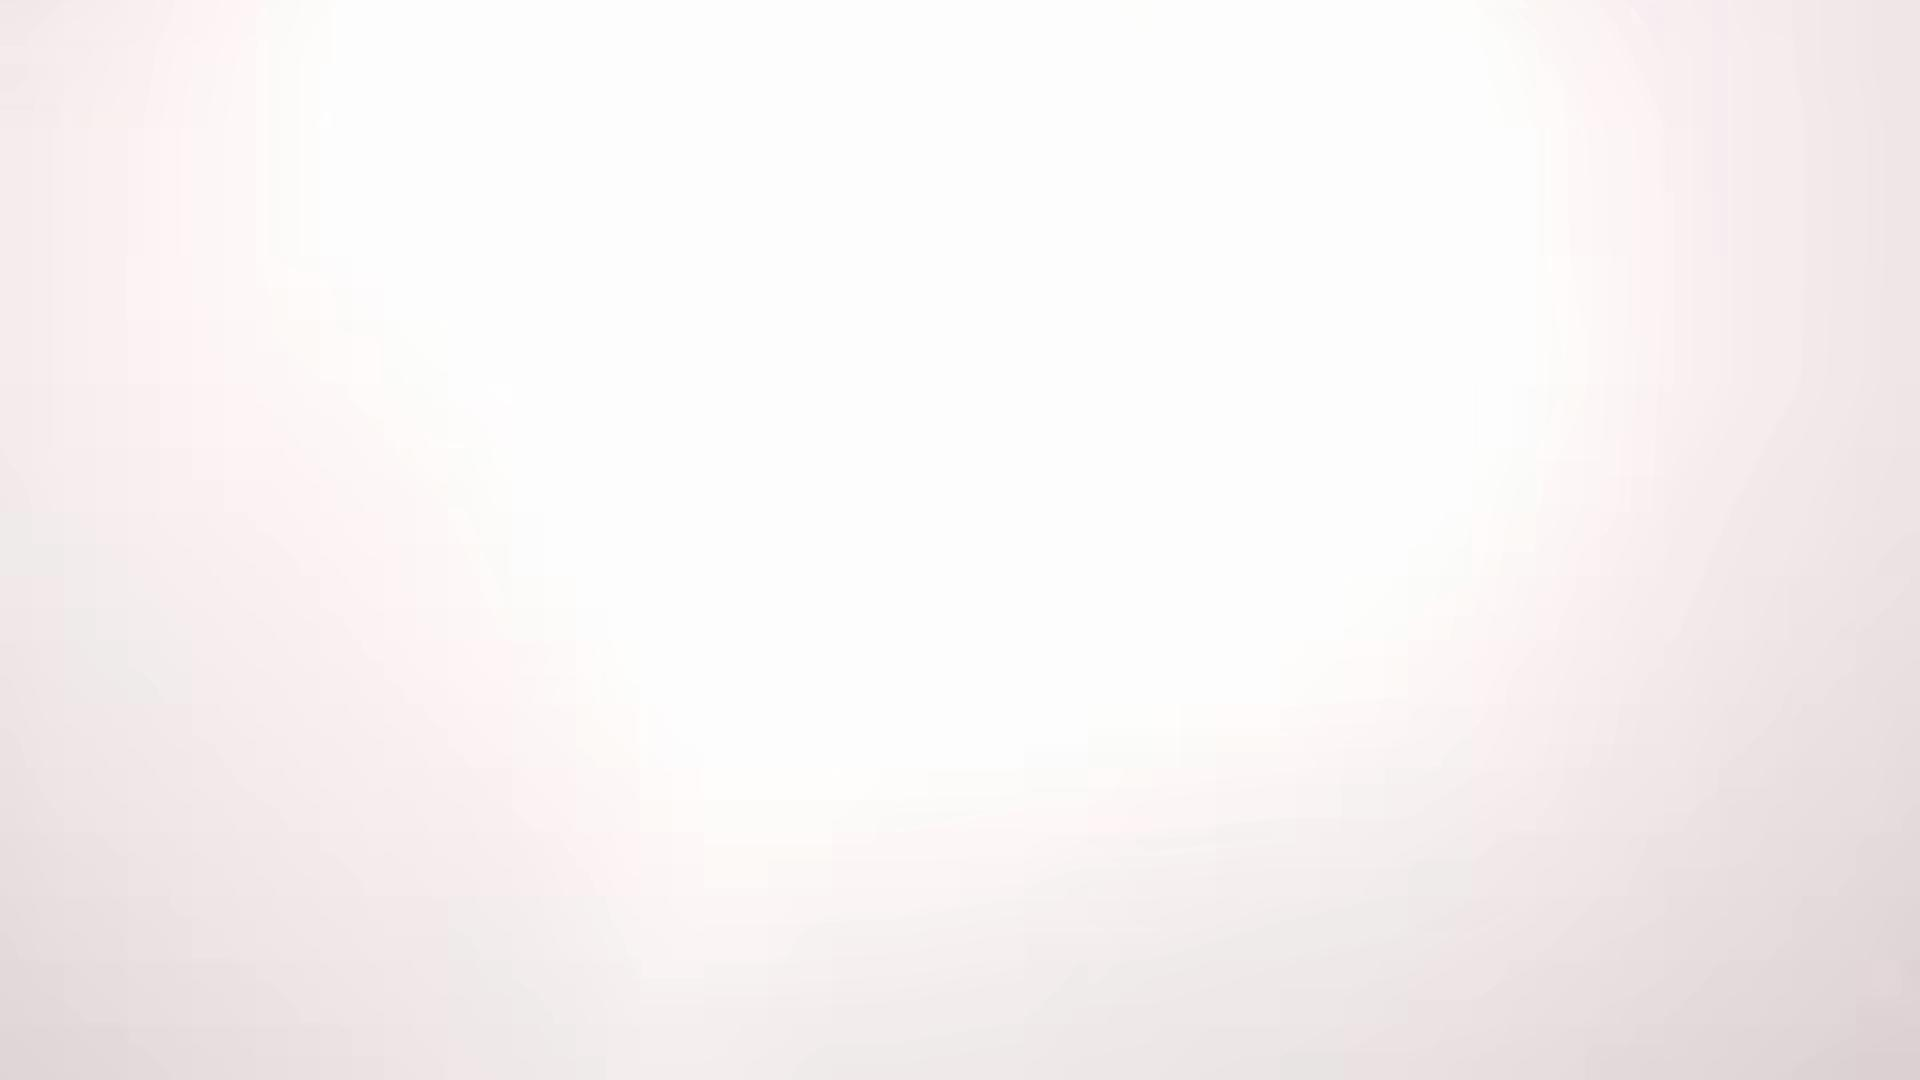
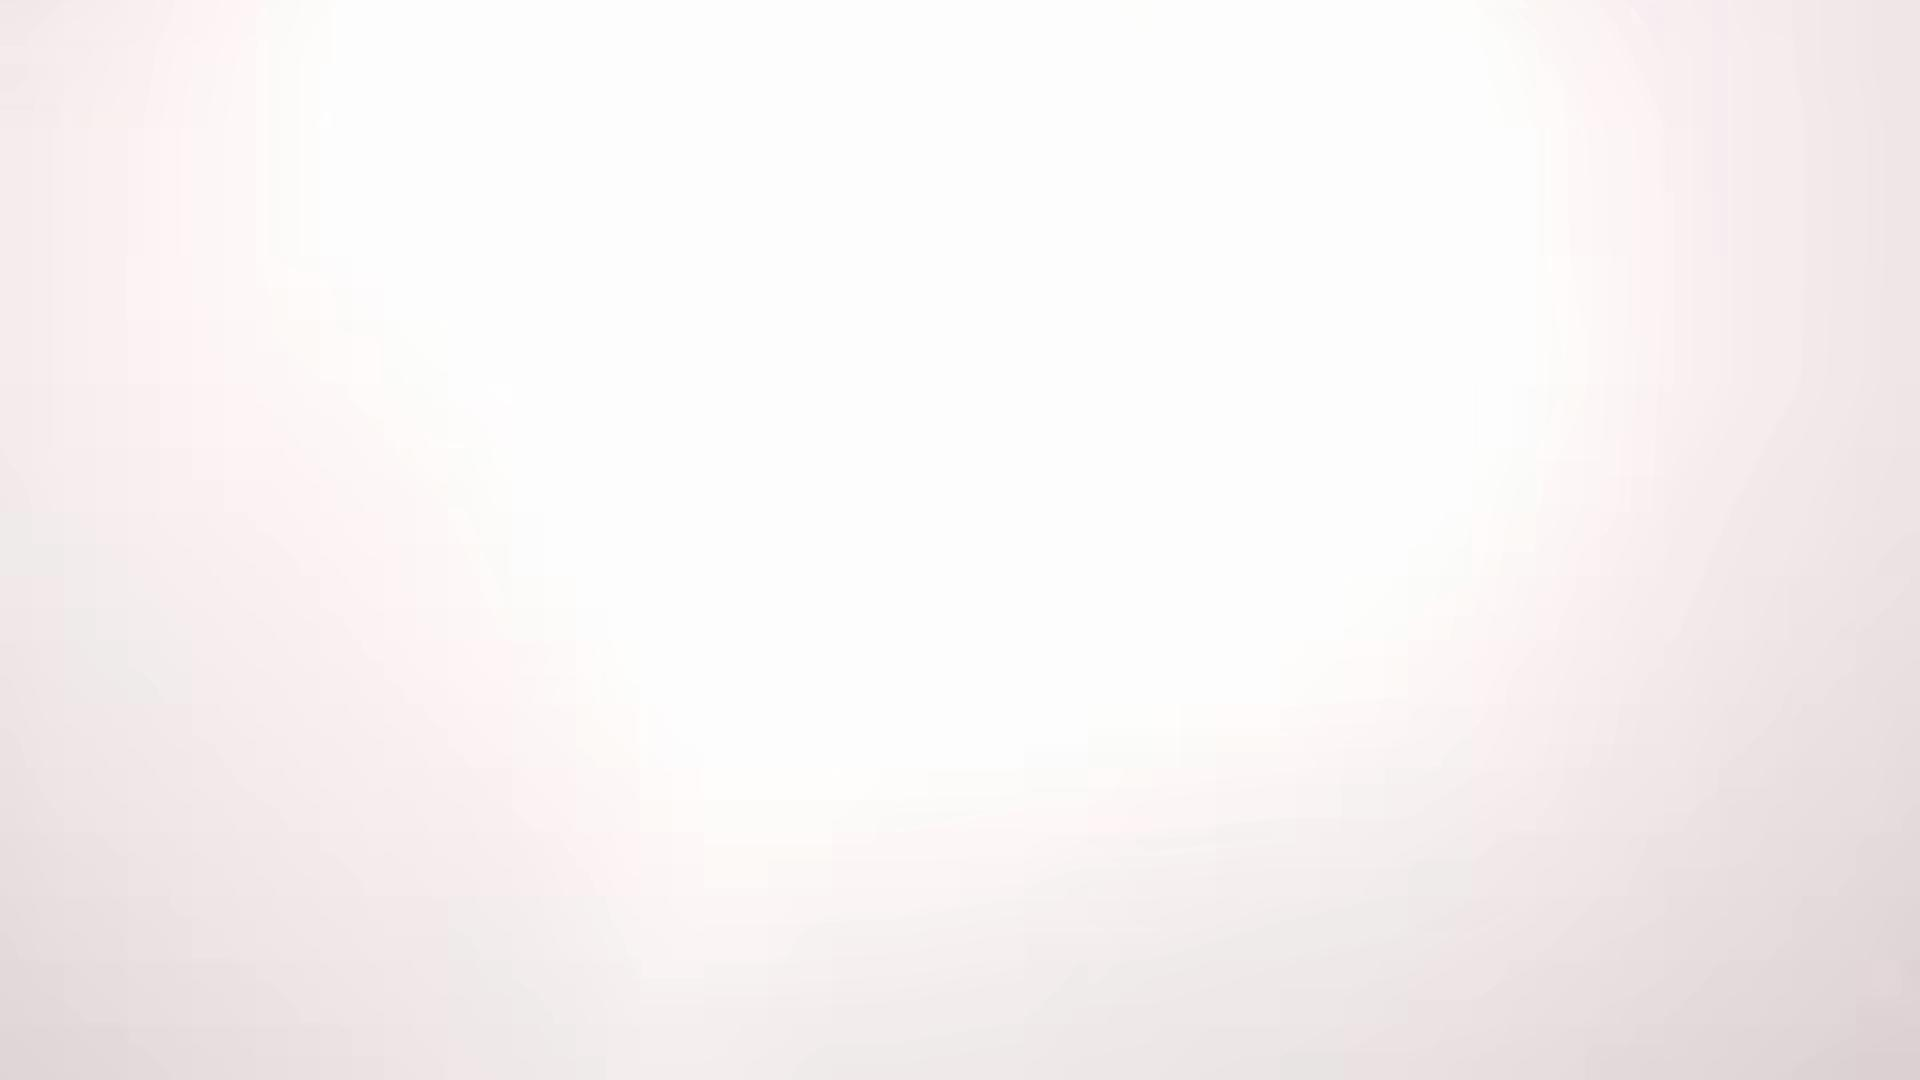
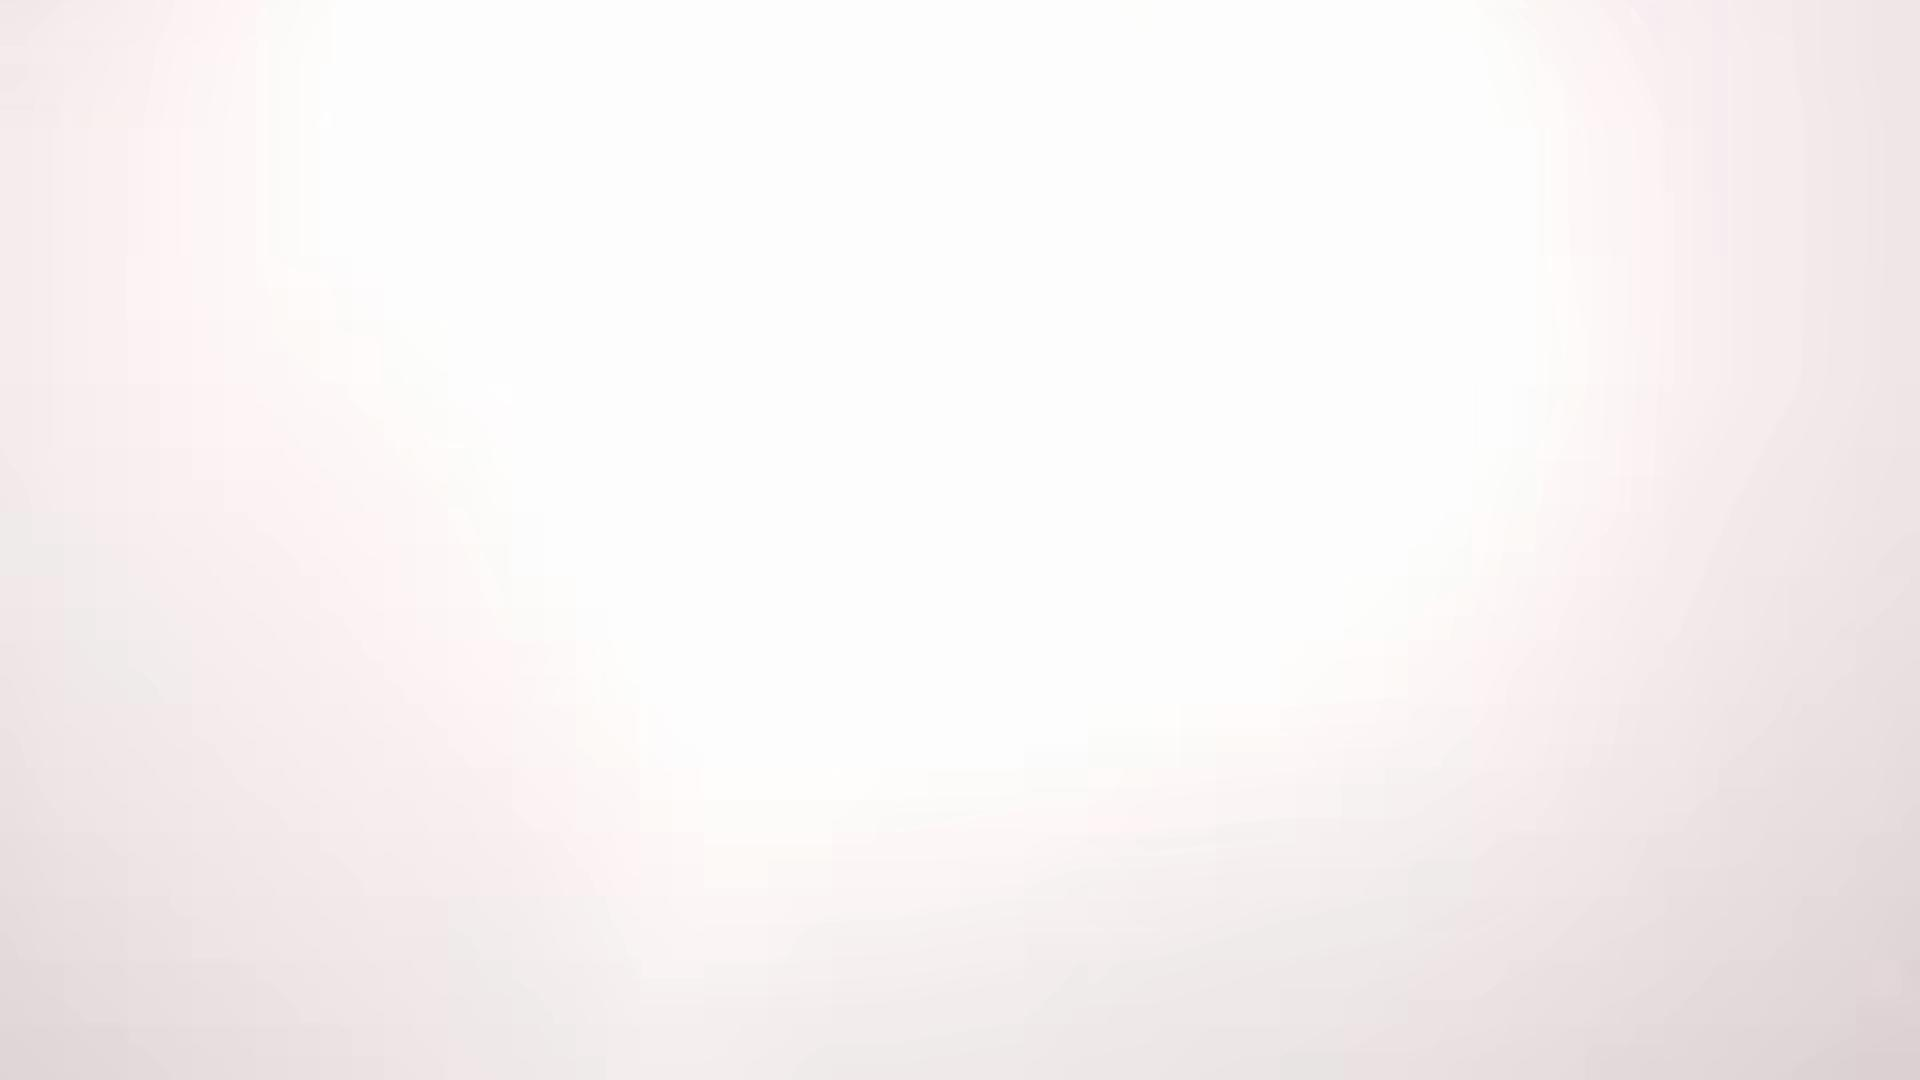

In [40]:
# Search for sentences about chess strategy
sim = sentences.text.similarity(string='chess strategy')

sentences.order_by(
    sim,
    asc=False
).select(
    sentences.video_segment,
    sentences.text,
    score=sim
).limit(3).collect()

We just built semantic search for video transcripts.

The workflow we defined:
- Detects scene boundaries using content-aware algorithms
- Creates a view with one row per scene segment
- Extracts audio and transcribes each scene automatically
- Splits transcripts into sentences for better embedding granularity
- Builds a searchable embedding index on sentences
- Finds relevant sentences by semantic similarity

Scenes, views, and computed columns work together to make video content searchable by meaning.

## 05 - Add a New Video

populates the views across the entire hierarchy
see it ripple through
one insert

We started this notebook with our `primetime_vids` table - I assigned it the handle `v` in my Python session. As a reminder, here is the schema for this table:

In [41]:
v

table 'primetime_vids'

 Column Name    Type                                      Computed With
       video   Video                                                   
       title  String                                                   
   promo_img   Image                                                   
  promo_text  String                                                   
    duration   Float                                get_duration(video)
      scenes    Json  video.scene_detect_histogram(fps=10,\n    thre...

And we have been iterating with data from a single row:

In [42]:
v.count()

1

Now it's time to demo our workflow in action. What will happen when we insert a new row into `primetime_vids`?



In [43]:
v.insert([{
    'video': 'source/only-murders-opening.mp4',
    'title': 'Only Murders in the Building',
    'promo_img': 'source/only-murders-img.jpg',
    'promo_text': 'Three strangers share an obsession with true crime and suddenly find themselves wrapped up in one. When a grisly death occurs inside their exclusive Upper West Side apartment building, the trio suspects murder and employs their precise knowledge of true crime to investigate the truth. Perhaps even more explosive are the lies they tell one another. Soon, the endangered trio comes to realize a killer might be living among them as they race to decipher the mounting clues before it is too late.'
}])

ERROR:asyncio:Exception in callback Task.__step()
handle: <Handle Task.__step() created at /Users/alison-pxt/miniconda3/lib/python3.13/asyncio/tasks.py:127>
source_traceback: Object created at (most recent call last):
  File "/Users/alison-pxt/Documents/Github/pxt-primetime/.venv/lib/python3.13/site-packages/nest_asyncio.py", line 133, in _run_once
    handle._run()
  File "/Users/alison-pxt/miniconda3/lib/python3.13/asyncio/events.py", line 89, in _run
    self._context.run(self._callback, *self._args)
  File "/Users/alison-pxt/miniconda3/lib/python3.13/asyncio/tasks.py", line 293, in __step
    self.__step_run_and_handle_result(exc)
  File "/Users/alison-pxt/miniconda3/lib/python3.13/asyncio/tasks.py", line 304, in __step_run_and_handle_result
    result = coro.send(None)
  File "/Users/alison-pxt/Documents/Github/pxt-primetime/.venv/lib/python3.13/site-packages/ipykernel/utils.py", line 60, in run_in_context
    return await asyncio.create_task(coro, context=context)
  File "/Users/

Inserted 112 rows with 0 errors in 59.81 s (1.87 rows/s)


112 rows inserted.

The schema won't change, because we just added a row - we didn't make any changes to columns.

In [44]:
v

table 'primetime_vids'

 Column Name    Type                                      Computed With
       video   Video                                                   
       title  String                                                   
   promo_img   Image                                                   
  promo_text  String                                                   
    duration   Float                                get_duration(video)
      scenes    Json  video.scene_detect_histogram(fps=10,\n    thre...

But we do have two computed columns: `duration` and `scenes`. Let's look to make sure Pixeltable orchestrated those computations upon insert:

video,title,promo_img,promo_text,duration,scenes
,The Queens Gambit,,"Set during the Cold War era, orphaned chess prodigy Beth Harmon struggles with addiction in a quest to become the greatest chess player in the world.",377.043,"[{""duration"": 28.779, ""start_pts"": 0, ""start_time"": 0.}, {""duration"": 16.85, ""start_pts"": 690690, ""start_time"": 28.779}, {""duration"": 80.122, ""start_pts"": 1095094, ""start_time"": 45.629}, {""duration"": 28.737, ""start_pts"": 3018015, ""start_time"": 125.751}, {""duration"": 25.734, ""start_pts"": 3707704, ""start_time"": 154.488}, {""duration"": 51.301, ""start_pts"": 4325321, ""start_time"": 180.222}, {""duration"": 70.32, ""start_pts"": 5556551, ""start_time"": 231.523}, {""duration"": 7.132, ""start_pts"": 7244237, ""start_time"": 301.843}, {""duration"": 41.458, ""start_pts"": 7415408, ""start_time"": 308.975}, {""duration"": 11.261, ""start_pts"": 8410402, ""start_time"": 350.433}]"
,Only Murders in the Building,,"Three strangers share an obsession with true crime and suddenly find themselves wrapped up in one. When a grisly death occurs inside their exclusive Upper West Side apartment building, the trio suspects murder and employs their precise knowledge of true crime to investigate the truth. Perhaps even more explosive are the lies they tell one another. Soon, the endangered trio comes to realize a killer might be living among them as they race to decipher the mounting clues before it is too late.",248.707,"[{""duration"": 6.84, ""start_pts"": 0, ""start_time"": 0.}, {""duration"": 12.596, ""start_pts"": 164164, ""start_time"": 6.84}, {""duration"": 10.594, ""start_pts"": 466466, ""start_time"": 19.436}, {""duration"": 10.594, ""start_pts"": 720720, ""start_time"": 30.03}, {""duration"": 74.491, ""start_pts"": 974974, ""start_time"": 40.624}, {""duration"": 17.226, ""start_pts"": 2762760, ""start_time"": 115.115}, {""duration"": 19.061, ""start_pts"": 3176173, ""start_time"": 132.341}, {""duration"": 86.42, ""start_pts"": 3633630, ""start_time"": 151.401}]"

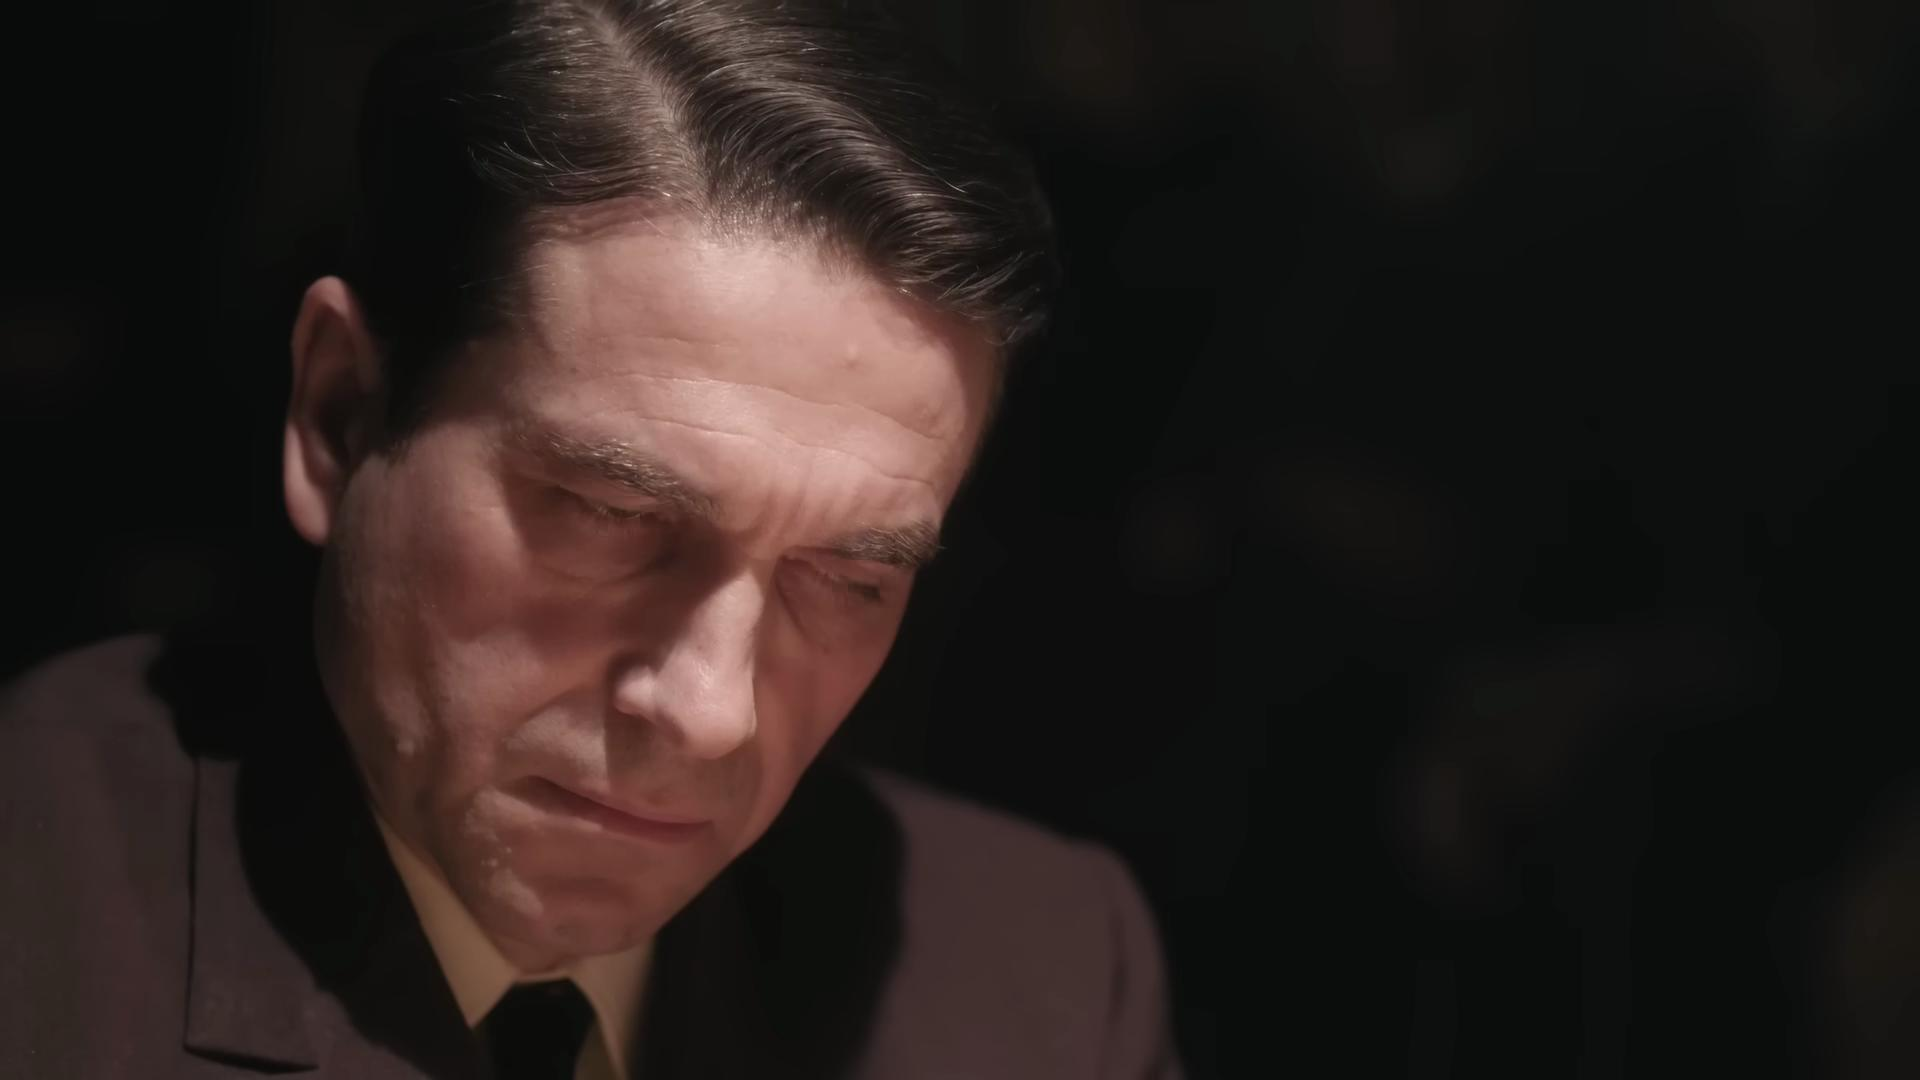
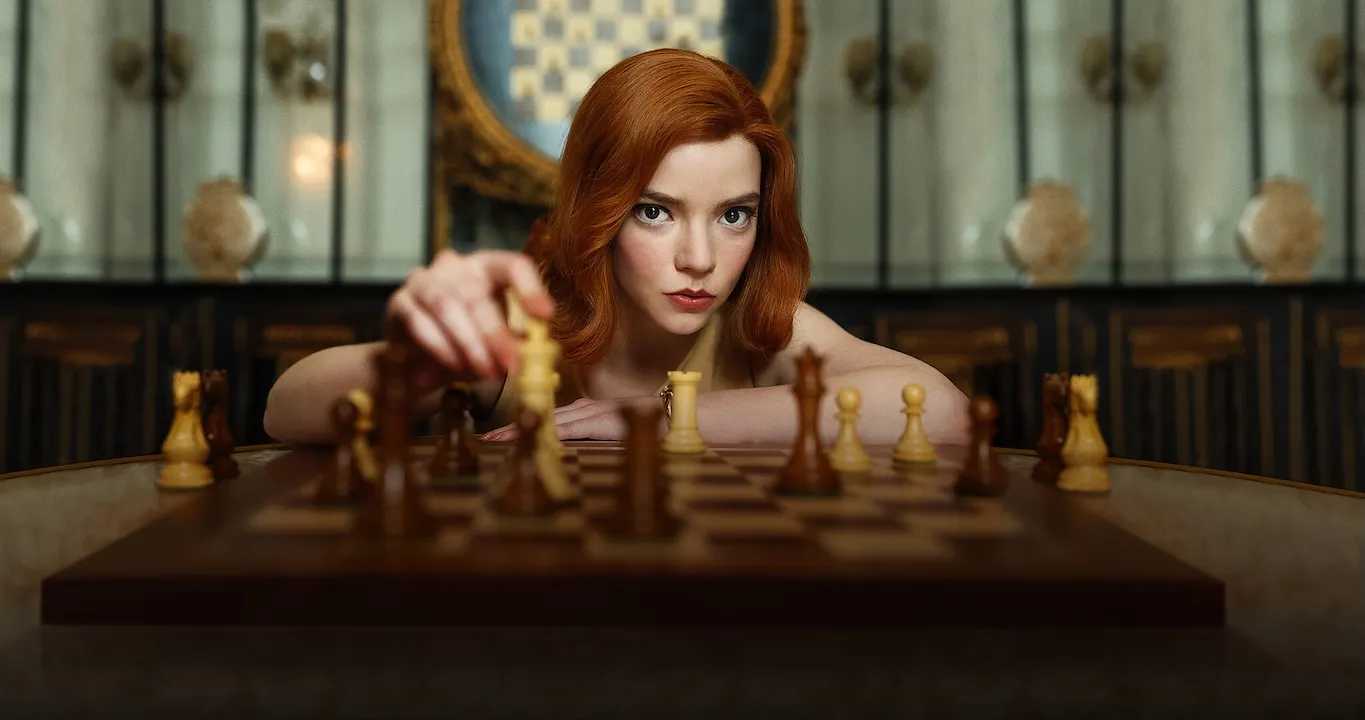
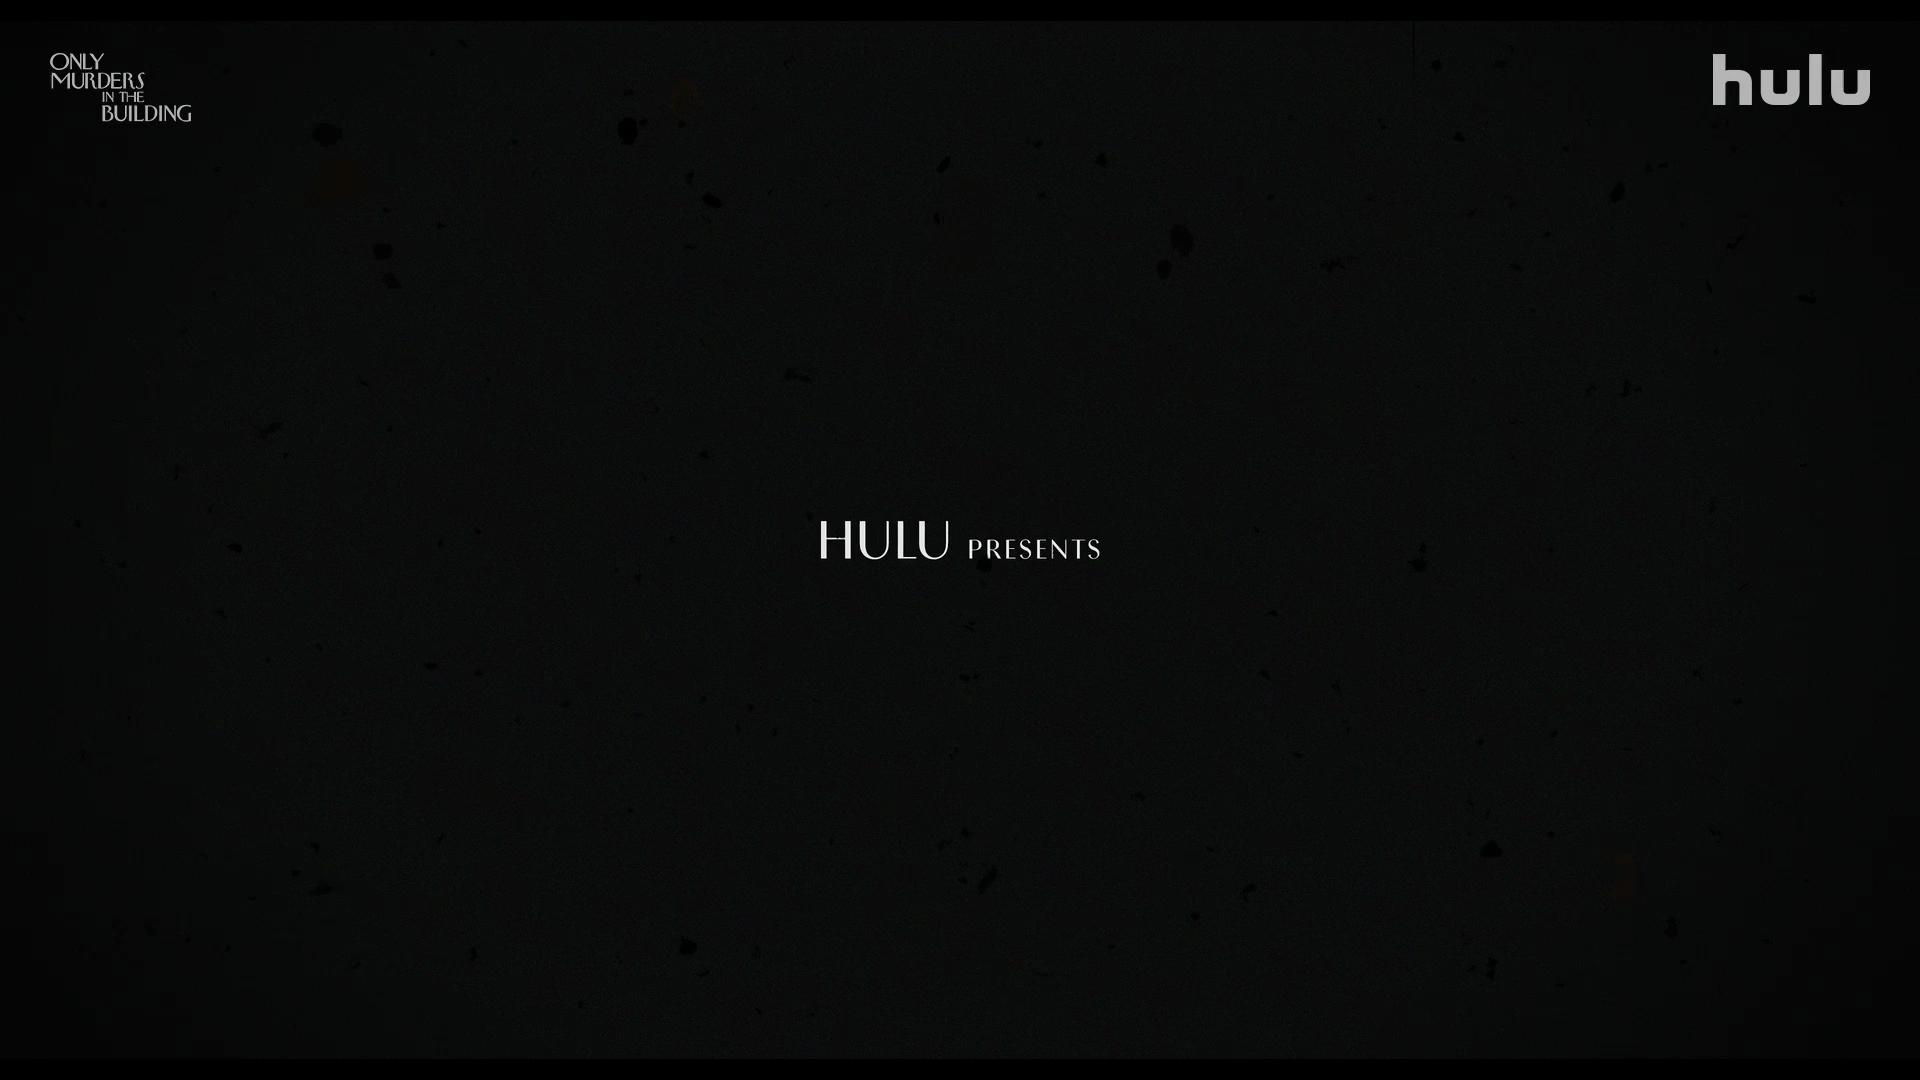
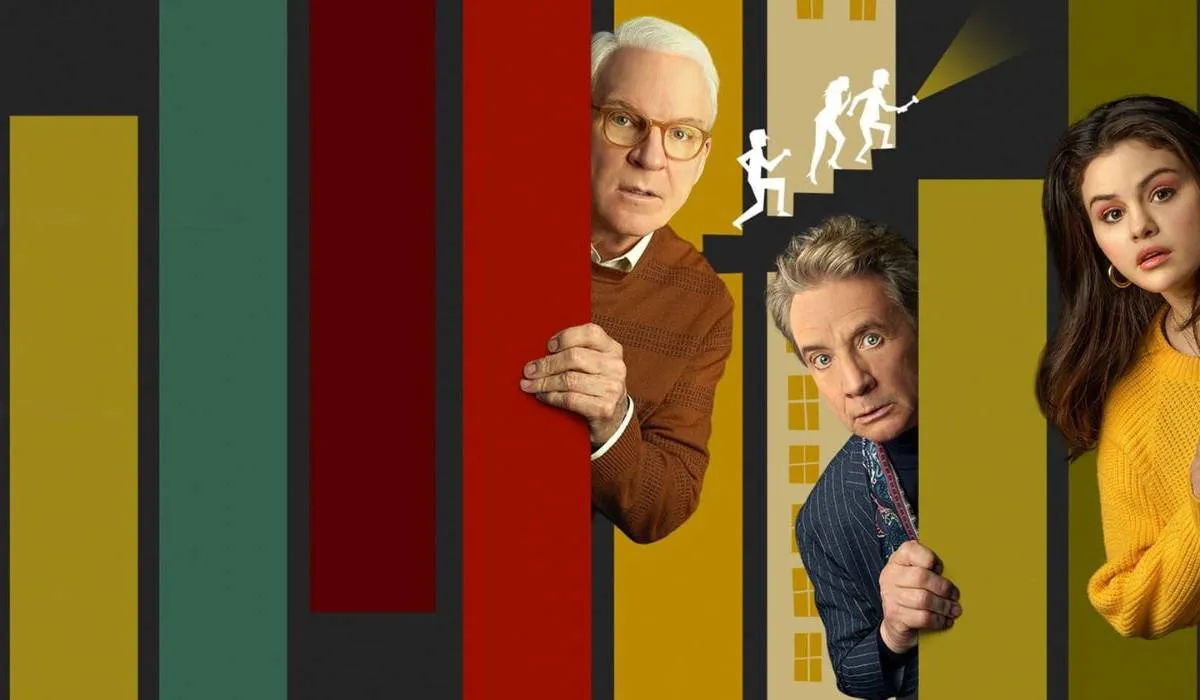

In [45]:
v.collect()

Remember: we also have a `scene_view` that derives from this base table.

In [46]:
pxt.list_tables()

['scene_view', 'primetime_vids', 'sentences']

Since I've been working with it in this notebook already, we use the handle `scenes` to review the schema:

In [47]:
scenes

view 'scene_view' (of 'primetime_vids')

        Column Name             Type                                      Computed With
                pos    Required[Int]                                                   
      segment_start            Float                                                   
  segment_start_pts              Int                                                   
        segment_end            Float                                                   
    segment_end_pts              Int                                                   
      video_segment  Required[Video]                                                   
              audio  Required[Audio]                       extract_audio(video_segment)
      transcription   Required[Json]                    transcribe(audio, model='base')
    transcript_text           String                  transcription.text.astype(String)
    transcript_lang           String              transcription.language.astype(String)
              video            Video                                                   
              title           String                                                   
          promo_img            Image                                                   
         promo_text           String                                                   
           duration            Float                                get_duration(video)
             scenes             Json  video.scene_detect_histogram(fps=10,\n    thre...

In [1]:
scenes.select(scenes.promo_img, scenes.video_segment, scenes.transcript_text).tail(2)

NameError: name 'scenes' is not defined

## Appendix - JSON Parsing Examples


This section covers JSON parsing in more detail, including step-by-step exploration of the JSON structure and different ways to access query results.


### Exploring JSON Structure

To create a view with video segments, we need to extract the scene start times from our `scenes` column. Let's build up to this step by step, exploring the JSON structure along the way. Learn more about [JSON operations](https://docs.pixeltable.com/platform/type-system).

**Step 1:** First, let's see what the `scenes` column contains:


In [ ]:
import pixeltable as pxt
v = pxt.get_table('primetime_vids')

In [ ]:
# Step 1: Look at the scenes column structure
v.select(v.scenes).collect()

**Step 2:** The `scenes` column contains a JSON array. Let's access the first scene to see its structure:

In [ ]:
# Step 2: Access the first scene element
v.select(v.scenes[0]).collect()

**Step 3:** Each scene has properties like `start_time` and `end_time`. Let's access the `start_time` of the first scene:


In [ ]:
# Step 3: Access the start_time property of the first scene
v.select(v.scenes[0].start_time).collect()


**Step 4:** Now let's slice the array to get all scenes from index 1 onwards (skipping the first scene, which typically starts at 0):


In [ ]:
# Step 4: Slice to get scenes from index 1 onwards
v.select(v.scenes[1:]).collect()

**Step 5:** Now access the `start_time` property for all scenes in the slice. Here, we'll also name the column `times`:


In [ ]:
# Step 5: Access start_time for all scenes from index 1 onwards
v.select(times=v.scenes[1:].start_time).collect()

### Accessing Query Results

Using `select()`, we are composing a query to run. When you run a query, Pixeltable gives you a few ways to interact with the results:

1. You can convert to a list of dictionaries
2. You can index by row/column `[0,0]` and by column name

**Example 1:** Convert to a list of dictionaries


In [ ]:
result = v.select(times=v.scenes[1:].start_time).collect()

In [ ]:
result  # Returns as a table

In [ ]:
result[0]  # Returns first row as dict

In [ ]:
result['times']  # Returns list of times values

**Example 2:** Index by row/column `[0,0]` and by column name

In [ ]:
# Index by position [row, column]
first_value = result[0, 0]  # First row, first column
first_value

In [ ]:
# Index by column name
first_time = result[0, "times"]  # First row, "times" column
first_time

## Wrap-Up

You built a semantic search pipeline for video transcripts using Pixeltable:

```
┌──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│  INPUT                 TRANSFORM 1              TRANSFORM 2                TRANSFORM 3              INDEX           SEARCH       │
│                                                                                                                                  │
│  ┌───────────┐    ┌──────────────────┐    ┌──────────────────────┐    ┌─────────────────────┐    ┌──────────┐    ┌──────────┐  │
│  │   Video   │───▶│  Scene Detection │───▶│  Scene Iterator      │───▶│  Audio & Transcribe │───▶│ Sentence │───▶│Similarity│  │
│  │ (queens-  │    │  (histogram)     │    │  (video_splitter)    │    │  (per scene)        │    │ Iterator │    │  Search  │  │
│  │  gambit)  │    │                  │    │                      │    │                     │    │(string_  │    │          │  │
│  └───────────┘    │  ┌────────────┐  │    │  ┌────────────────┐  │    │  ┌───────────────┐  │    │splitter) │    │ ┌──────┐ │  │
│                   │  │ Timestamps │  │    │  │ Scene Segments │  │    │  │ Audio Extract │  │    │          │    │ │Query:│ │  │
│  TABLE:           │  │ (computed) │──┼───▶│  │ (view rows)    │──┼───▶│  │   (computed)  │  │    │  ┌─────┐ │    │ │"chess│ │  │
│  primetime_vids   │  └────────────┘  │    │  └────────────────┘  │    │  └───────┬───────┘  │    │  │Sent-│ │    │ │game" │ │  │
│                   └──────────────────┘    │                      │    │          ▼          │    │  │ence │ │    │ └──┬───┘ │  │
│                                           │                      │    │  ┌───────────────┐  │    │  │rows │ │    │    │     │  │
│                                           │                      │    │  │  Transcripts  │──┼───▶│  │+emb │─┼───▶│ ┌──▼───┐ │  │
│                                           │                      │    │  │   (Whisper)   │  │    │  └─────┘ │    │ │Result│ │  │
│                                           │                      │    │  └───────────────┘  │    │          │    │ │ranked│─┼─▶│
│                                           │  VIEW: scene_view    │    │                     │    │  VIEW:   │    │ └──────┘ │  │
│                                           └──────────────────────┘    └─────────────────────┘    │sentences │    └──────────┘  │
│                                                                                                  └──────────┘                    │
└──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘
```

**What you built:**

You added a second search modality to your video pipeline. Act 1 gave you visual similarity search (find frames by what they look like). Act 2 gives you semantic audio search (find scenes by what's being said).

Together, these two modalities let you search video comprehensively: by visual content and by semantic meaning in the audio. Search for "chess game" visually to find chess boards, or search transcripts to find moments where people discuss strategy.

**Each step is declarative:**
- **Input**: Video data persists in the database
- **Transform**: Scene detection, splitting, audio extraction, and transcription all run automatically via computed columns
- **Index**: Embedding index makes transcripts searchable by semantic meaning
- **Search**: Query scenes by what's being said, complementing the visual search from Act 1

---

## Learn More

### Views & Iterators
- [Views Platform Guide](https://docs.pixeltable.com/platform/views) - Creating and using views
- [Iterators Platform Guide](https://docs.pixeltable.com/platform/iterators) - Working with iterators
- [`video_splitter()`](https://docs.pixeltable.com/sdk/latest/video#iterator-video_splitter) - Video segmentation iterator
- [`string_splitter()`](https://docs.pixeltable.com/sdk/latest/string#iterator-string_splitter) - Text segmentation iterator
- [`create_view()`](https://docs.pixeltable.com/sdk/latest/pixeltable#func-create-view) - View creation API

### Scene Detection
- [Video Functions](https://docs.pixeltable.com/sdk/latest/video) - Scene detection functions
- [`scene_detect_histogram()`](https://docs.pixeltable.com/sdk/latest/video#udf-scene_detect_histogram) - Content-based scene detection

### Audio & Transcription
- [`extract_audio()`](https://docs.pixeltable.com/sdk/latest/video#udf-extract_audio) - Extract audio from video
- [Whisper Functions](https://docs.pixeltable.com/sdk/latest/whisper) - Local Whisper transcription
- [OpenAI Functions](https://docs.pixeltable.com/sdk/latest/openai) - OpenAI API transcription

### JSON Operations
- [Type System](https://docs.pixeltable.com/platform/type-system) - Working with JSON and other types
- [JSON Operations](https://docs.pixeltable.com/platform/type-system) - Accessing and manipulating JSON data

### Embeddings & Search
- [Embedding Indexes](https://docs.pixeltable.com/platform/embedding-indexes) - Building searchable indexes
- [`sentence_transformer()`](https://docs.pixeltable.com/sdk/latest/huggingface#sentence-transformer) - Text embeddings
- [Similarity Search Cookbooks](https://docs.pixeltable.com/howto/cookbooks/search/search-similar-text) - Text similarity search
- [HuggingFace Integration](https://docs.pixeltable.com/sdk/latest/huggingface) - Working with HuggingFace models

## Functions Used

This notebook uses the following Pixeltable functions:

- [`add_computed_column()`](https://docs.pixeltable.com/sdk/latest/pixeltable#add-computed-column) - Add computed columns to tables
- [`add_embedding_index()`](https://docs.pixeltable.com/sdk/latest/pixeltable#add-embedding-index) - Create embedding indexes for similarity search
- [`create_view()`](https://docs.pixeltable.com/sdk/latest/pixeltable#func-create-view) - Create views from tables
- [`extract_audio()`](https://docs.pixeltable.com/sdk/latest/video#udf-extract_audio) - Extract audio from video segments
- [`get_table()`](https://docs.pixeltable.com/sdk/latest/pixeltable#func-get-table) - Retrieve existing tables
- [`list_tables()`](https://docs.pixeltable.com/sdk/latest/pixeltable#func-list-tables) - List all tables in the database
- [`scene_detect_histogram()`](https://docs.pixeltable.com/sdk/latest/video#udf-scene_detect_histogram) - Detect scene boundaries in video
- [`similarity()`](https://docs.pixeltable.com/sdk/latest/pixeltable#similarity) - Perform similarity search using embedding indexes
- [`string_splitter()`](https://docs.pixeltable.com/sdk/latest/string#iterator-string_splitter) - Iterator to split text into segments
- [`transcribe()`](https://docs.pixeltable.com/sdk/latest/whisper#udf-transcribe) - Transcribe audio using Whisper
- [`video_splitter()`](https://docs.pixeltable.com/sdk/latest/video#iterator-video_splitter) - Iterator to split video into segments